In [8]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer
from massspecgym.tools.io import load_embeddings
from massspecgym.tools.data import get_embedding_for_node
from sklearn.metrics.pairwise import cosine_similarity

import json
import os
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem

import pandas as pd
import numpy as np
from collections import defaultdict, deque
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import seaborn as sns
import umap

from matchms import Spectrum
from matchms.similarity import CosineHungarian
from itertools import combinations



## Local definistion of functions

In [9]:
RDLogger.DisableLog('rdApp.*')

def load_unique_smiles(smiles_list):
    """
    Extract unique SMILES from the dataset and canonicalize them.
    
    Parameters:
        smiles_list (list of smiles): Your dataset containing a 'smiles' column.
    
    Returns:
        dict: Mapping of original SMILES to their canonical forms.
    """

    canonical_map = {}
    for smi in smiles_list:
        canonical = canonicalize_smiles(smi)
        canonical_map[smi] = canonical
    return canonical_map

def canonicalize_smiles(smiles):
    """
    Canonicalize a SMILES string using RDKit.
    
    Parameters:
        smiles (str): The SMILES string to canonicalize.
    
    Returns:
        str or None: The canonical SMILES string, or None if invalid.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        else:
            return None
    except:
        return None
    
def get_ms_level(node) -> Optional[int]:
    """
    Return the ms_level from node's spectrum metadata if present.
    """
    if node is None or node.spectrum is None:
        return None
    ms_level_str = node.spectrum.get('ms_level')
    if ms_level_str is not None:
        return int(ms_level_str)
    return None

def gather_nodes_by_level_in_tree(tree) -> Dict[int, List]:
    """
    Gather all nodes from 'tree' grouped by their ms_level.
    Returns a dictionary: { ms_level (int) -> list of TreeNodes }.
    """
    nodes_by_level = defaultdict(list)

    # BFS to traverse the tree
    queue = deque([tree.root])
    while queue:
        node = queue.popleft()
        # Get ms_level from node
        lvl = get_ms_level(node)
        if lvl is not None:
            nodes_by_level[lvl].append(node)

        # Enqueue children
        for child in node.children.values():
            queue.append(child)

    return dict(nodes_by_level)  

def plot_attribute_distribution(df, ms_level, attribute, output_svg=False):
    """
    Plot the distribution of a specified attribute for a given ms_level,
    and include min and max values in the plot title.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the attribute and 'ms_level'.
        ms_level (int): The ms_level to filter the data.
        attribute (str): The attribute to plot (e.g., 'precursor_mz' or 'num_peaks').
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """
    # Validate attribute
    if attribute not in df.columns:
        print(f"Attribute '{attribute}' not found in the DataFrame.")
        return
    
    # Filter the DataFrame for the specified ms_level
    df_level = df[df['ms_level'] == ms_level]
    
    # Check if there are data points for the specified ms_level
    if df_level.empty:
        print(f"No data available for ms_level {ms_level}.")
        return
    
    # Compute min and max of the attribute
    attribute_min = df_level[attribute].min()
    attribute_max = df_level[attribute].max()
    
    # Plot setup
    plt.figure(figsize=(8, 6))
    
    # Determine if the attribute is continuous or discrete
    if pd.api.types.is_numeric_dtype(df_level[attribute]):
        # Plot histogram with KDE
        sns.histplot(df_level[attribute].dropna(), kde=True, bins=50, color='skyblue')
        plt.xlabel(attribute.replace('_', ' ').capitalize())
        plt.ylabel('Frequency')
        plt.title(
            f'Distribution of {attribute.replace("_", " ").capitalize()} '
            f'for MS Level {ms_level}\n'
            f'(Min: {attribute_min:.2f}, Max: {attribute_max:.2f})'
        )
    else:
        # Plot countplot for categorical data
        sns.countplot(data=df_level, x=attribute, palette='viridis')
        plt.xlabel(attribute.replace('_', ' ').capitalize())
        plt.ylabel('Count')
        plt.title(
            f'Count of {attribute.replace("_", " ").capitalize()} '
            f'for MS Level {ms_level}\n'
            f'(Unique Values: {df_level[attribute].nunique()})'
        )
    
    # Save the plot
    if output_svg:
        plt.savefig(f'{attribute}_distribution_ms_level_{ms_level}.svg')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
def plot_attribute_overlay(df, attribute, output_svg=False):
    """
    Plot overlay distributions of precursor_mz across all ms_levels.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'precursor_mz' and 'ms_level'.
        attribute (str): The attribute to plot (e.g., 'precursor_mz' or 'num_peaks').
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """

    if attribute not in df.columns:
        print(f"Attribute '{attribute}' not found in the DataFrame.")
        return
    
    # Remove rows with NaN precursor_mz
    df_clean = df
    
    # Check if there are data points
    if df_clean.empty:
        print("No data available for plotting precursor_mz distributions.")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Define a contrastive color palette
    ms_levels = df_clean['ms_level'].unique()
    palette = sns.color_palette("tab10", len(ms_levels))
    level_colors = dict(zip(ms_levels, palette))
    
    # Plot KDE for each ms_level
    for level, color in level_colors.items():
        sns.kdeplot(
            data=df_clean[df_clean['ms_level'] == level],
            x=attribute,
            fill=True,
            alpha=0.6,
            label=f'MS Level {level}',
            color=color
        )
    
    # Set axis labels and title
    plt.xlabel(attribute.replace('_', ' ').capitalize(), fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Overlay Distribution of {attribute.replace("_", " ").capitalize()} Across MS Levels', fontsize=16)
    
    # Create a custom legend
    custom_legend = [
        plt.Line2D([0], [0], color=color, lw=4, label=f'MS Level {level}')
        for level, color in level_colors.items()
    ]
    plt.legend(handles=custom_legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if needed
    if output_svg:
        plt.savefig(f'{attribute}_overlay_all_ms_levels.svg')
    
    plt.show()

def plot_umap_attribute(
    data,
    min_num_peaks=None,
    max_num_peaks=None,
    samples=None,
    attribute="max_peak",
    is_continuous=True,
    alpha=0.6,
    s=3,
    output_svg=False
):
    """
    Plot UMAP projection colored by a specified attribute, applying sampling and exclusion thresholds.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', 'num_peaks', and the specified attribute.
        min_num_peaks (int, optional): Minimum 'num_peaks' value to include. Excludes data points with 'num_peaks' < min_num_peaks.
        max_num_peaks (int, optional): Maximum 'num_peaks' value to include. Excludes data points with 'num_peaks' > max_num_peaks.
        samples (int, optional): Number of samples to take from the filtered data. If None, uses all filtered data.
        attribute (str): Column name to color the points by.
        is_continuous (bool): If True, treats the attribute as continuous; otherwise, as categorical.
        alpha (float): Transparency level for scatter plot points (0.0 transparent through 1.0 opaque).
        s (float): Size of scatter plot points.
        output_svg (bool): Whether to save the plot as an SVG file.

    Returns:
        None
    """
    # 1. Validate required columns
    required_cols = ['UMAP_1', 'UMAP_2', 'num_peaks', attribute]
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        print(f"Error: DataFrame is missing the following required column(s): {missing_cols}")
        return

    # 2. Filter data based on min_num_peaks and max_num_peaks
    data_filtered = data.copy()

    if min_num_peaks is not None:
        initial_count = data_filtered.shape[0]
        data_filtered = data_filtered[data_filtered['num_peaks'] >= min_num_peaks]
        print(f"Applied min_num_peaks threshold: {min_num_peaks}")
        print(f"Data points before min filtering: {initial_count}")
        print(f"Data points after min filtering: {data_filtered.shape[0]}")

    if max_num_peaks is not None:
        initial_count = data_filtered.shape[0]
        data_filtered = data_filtered[data_filtered['num_peaks'] <= max_num_peaks]
        print(f"Applied max_num_peaks threshold: {max_num_peaks}")
        print(f"Data points before max filtering: {initial_count}")
        print(f"Data points after max filtering: {data_filtered.shape[0]}")

    # 3. Sample data if required
    if samples is not None:
        total_filtered = data_filtered.shape[0]
        if samples >= total_filtered:
            data_sampled = data_filtered.copy()
            print(f"\nSampling not needed: Requested samples ({samples}) >= available data ({total_filtered}). Using all filtered data.")
        else:
            data_sampled = data_filtered.sample(n=samples, random_state=42).reset_index(drop=True)
            print(f"\nSampling applied: Randomly sampled {samples} data points from the filtered data.")
    else:
        data_sampled = data_filtered.copy()
        print("\nSampling not applied: Using all data after filtering.")

    # 4. Check for missing values in the attribute
    missing_attr = data_sampled[attribute].isna().sum()
    if missing_attr > 0:
        print(f"Warning: {missing_attr} data point(s) have NaN in the attribute '{attribute}' and will be excluded from the plot.")
        data_sampled = data_sampled.dropna(subset=[attribute])

    # 5. Plotting
    plt.figure(figsize=(14, 10))

    if is_continuous:
        # Continuous attribute: Use a color map with a color bar
        scatter = plt.scatter(
            x=data_sampled['UMAP_1'],
            y=data_sampled['UMAP_2'],
            c=data_sampled[attribute],
            cmap='viridis',
            alpha=alpha,
            s=s
        )
        cbar = plt.colorbar(scatter)
        cbar.set_label(attribute, fontsize=12)
    else:
        # Categorical attribute: Assign distinct colors and create a custom legend
        unique_values = data_sampled[attribute].unique()
        palette = sns.color_palette("tab10", len(unique_values))
        color_mapping = dict(zip(unique_values, palette))
        data_sampled['color'] = data_sampled[attribute].map(color_mapping)

        plt.scatter(
            x=data_sampled['UMAP_1'],
            y=data_sampled['UMAP_2'],
            c=data_sampled['color'],
            alpha=alpha,
            s=s
        )

        # Create custom legend with square markers
        legend_elements = [
            plt.Line2D([0], [0], marker='s', color='w', label=val, markerfacecolor=color_mapping[val], markersize=10)
            for val in unique_values
        ]
        plt.legend(handles=legend_elements, title=attribute, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    # Titles and labels
    plt.title(f'UMAP Projection Colored by {attribute}', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save plot if required
    if output_svg:
        plt.savefig(f'UMAP_{attribute}_Plot.svg', format='svg')

    # Display plot
    plt.show()

def plot_umap_num_peaks(data, bins=10, sample_by_bins=False, output_svg=False):
    """
    Plot UMAP projection colored by num_peaks, with optional bin sampling.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', and 'num_peaks'.
        bins (int): Number of bins to group num_peaks into.
        sample_by_bins (bool): Whether to sample data to balance bins.
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """
    # Ensure necessary columns exist
    required_cols = ['UMAP_1', 'UMAP_2', 'num_peaks']
    if not all(col in data.columns for col in required_cols):
        print(f"DataFrame must contain columns: {required_cols}")
        return
    
    # Make a copy of the DataFrame to avoid modifying the original data
    data_clean = data.copy()
    
    # Remove rows with NaN num_peaks
    data_clean = data_clean.dropna(subset=['num_peaks'])
    
    # Check if there are data points after cleaning
    if data_clean.empty:
        print("No data available for plotting num_peaks distributions.")
        return
    
    # Ensure num_peaks is integer (since it's a count)
    data_clean['num_peaks'] = data_clean['num_peaks'].astype(int)
    
    # Bin the num_peaks values
    min_peaks = data_clean['num_peaks'].min()
    max_peaks = data_clean['num_peaks'].max()
    
    # Define bin edges ensuring all integer values are covered
    bin_edges = np.linspace(min_peaks, max_peaks, bins + 1)
    bin_edges = np.floor(bin_edges).astype(int)
    bin_edges[-1] = max_peaks + 1  # Ensure the max_peaks is included
    
    # Define bin labels as string ranges
    bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    
    # Assign bins to num_peaks
    data_clean['num_peaks_binned'] = pd.cut(
        data_clean['num_peaks'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True,
        right=False  # Left-inclusive, right-exclusive
    )
    
    # Convert categorical labels to strings for mapping
    data_clean['num_peaks_binned'] = data_clean['num_peaks_binned'].astype(str)
    
    # Sample data by bins if requested
    if sample_by_bins:
        # Find the least populated bin
        bin_counts = data_clean['num_peaks_binned'].value_counts()
        min_bin_size = bin_counts.min()
        
        # Sample an equal number of cases from each bin
        try:
            data_clean = data_clean.groupby('num_peaks_binned').sample(
                n=min_bin_size, random_state=42
            ).reset_index(drop=True)
        except Exception as e:
            print(f"Error during sampling: {e}")
            return
    
    # Assign colors to bins
    if bins <= 10:
        cmap = sns.color_palette("tab10", bins)
    elif bins <= 20:
        cmap = sns.color_palette("tab20", bins)
    else:
        cmap = sns.color_palette("viridis", bins)
    
    bin_colors = dict(zip(bin_labels, cmap))
    
    # Map colors to binned data
    data_clean['bin_color'] = data_clean['num_peaks_binned'].map(bin_colors)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot
    plt.scatter(
        x=data_clean['UMAP_1'],
        y=data_clean['UMAP_2'],
        c=data_clean['bin_color'],
        alpha=0.5,
        s=0.40
    )
    
    # Create a custom legend
    present_bins = data_clean['num_peaks_binned'].unique()
    custom_legend = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=bin_colors[bin_label], markersize=10, label=bin_label)
        for bin_label in present_bins
    ]
    plt.legend(handles=custom_legend, title='Num Peaks Binned', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Enhance the plot with titles and labels
    plt.title('UMAP Projection Colored by Binned Num Peaks', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if needed
    if output_svg:
        plt.savefig('UMAP_Num_Peaks_Overlay.svg', format='svg')
    
    # Show the plot
    plt.show()
    
def plot_umap_num_peaks_proportional(
    data,
    bins=10,
    sample_by_bins=False,
    max_per_bin=1000,
    max_num_peaks=None,
    min_num_peaks=None,
    alpha=0.6,
    s=0.5,
    output_svg=False
):
    """
    Plot UMAP projection colored by num_peaks, with optional bin sampling and exclusion thresholds.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', and 'num_peaks'.
        bins (int): Number of bins to group num_peaks into.
        sample_by_bins (bool): Whether to sample data to limit the number of samples per bin.
        max_per_bin (int): Maximum number of samples per bin to prevent overplotting.
        max_num_peaks (int, optional): Maximum num_peaks value to include. Data points with num_peaks > max_num_peaks will be excluded.
        min_num_peaks (int, optional): Minimum num_peaks value to include. Data points with num_peaks < min_num_peaks will be excluded.
        alpha (float): Transparency level for scatter plot points (0.0 transparent through 1.0 opaque).
        s (float): Size of scatter plot points.
        output_svg (bool): Whether to save the plot as an SVG file.

    Returns:
        None
    """
    # 1. Validate the presence of required columns
    required_cols = ['UMAP_1', 'UMAP_2', 'num_peaks']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        print(f"Error: DataFrame is missing the following required column(s): {missing_cols}")
        return

    # 2. Make a copy of the DataFrame to avoid modifying the original data
    data_clean = data.copy()

    # 3. Remove rows with NaN in critical columns
    data_clean = data_clean.dropna(subset=required_cols)

    # 4. Check if there are data points after cleaning
    if data_clean.empty:
        print("No data available for plotting.")
        return

    # 5. Ensure num_peaks is integer (since it's a count)
    try:
        data_clean['num_peaks'] = data_clean['num_peaks'].astype(int)
    except ValueError:
        print("Error: 'num_peaks' column contains non-integer values that cannot be converted.")
        return

    # 6. Apply the max_num_peaks threshold if specified
    if max_num_peaks is not None:
        data_before_threshold = data_clean.shape[0]
        data_clean = data_clean[data_clean['num_peaks'] <= max_num_peaks].reset_index(drop=True)
        data_after_threshold = data_clean.shape[0]
        print(f"Applied max_num_peaks threshold: {max_num_peaks}")
        print(f"Data points before thresholding: {data_before_threshold}")
        print(f"Data points after thresholding: {data_after_threshold}")
    else:
        print("No max_num_peaks threshold applied.")

    # 7. Apply the min_num_peaks threshold if specified
    if min_num_peaks is not None:
        data_before_min_threshold = data_clean.shape[0]
        data_clean = data_clean[data_clean['num_peaks'] >= min_num_peaks].reset_index(drop=True)
        data_after_min_threshold = data_clean.shape[0]
        print(f"Applied min_num_peaks threshold: {min_num_peaks}")
        print(f"Data points before min thresholding: {data_before_min_threshold}")
        print(f"Data points after min thresholding: {data_after_min_threshold}")
    else:
        print("No min_num_peaks threshold applied.")

    # 8. Bin the num_peaks values
    min_peaks = data_clean['num_peaks'].min()
    max_peaks = data_clean['num_peaks'].max()

    if bins < 1:
        print("Error: 'bins' must be at least 1.")
        return

    # Define bin edges ensuring all integer values are covered
    if bins == 1:
        bin_edges = [min_peaks, max_peaks + 1]
        bin_labels = [f"{min_peaks}-{max_peaks}"]
    else:
        bin_edges = np.linspace(min_peaks, max_peaks, bins + 1)
        bin_edges = np.floor(bin_edges).astype(int)
        bin_edges[-1] = max_peaks + 1  # Ensure the max_peaks is included

        # Define bin labels as string ranges
        bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

    # Assign bins to num_peaks
    data_clean['num_peaks_binned'] = pd.cut(
        data_clean['num_peaks'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True,
        right=False  # Left-inclusive, right-exclusive
    )

    # Convert categorical labels to strings for mapping
    data_clean['num_peaks_binned'] = data_clean['num_peaks_binned'].astype(str)

    # 9. Sampling data by bins if requested
    if sample_by_bins and bins >= 1:
        # Sort bin labels based on the lower bound of the bin
        def extract_lower_bound(bin_label):
            try:
                return int(bin_label.split('-')[0])
            except:
                return np.inf  # Handle any unexpected bin label format

        sorted_bins = sorted(bin_labels, key=lambda x: extract_lower_bound(x))

        # Group data by bins in sorted order
        grouped = data_clean.groupby('num_peaks_binned')

        # Apply sampling: sample up to max_per_bin per bin
        sampled_dfs = []
        for bin_label in sorted_bins:
            if bin_label in grouped.groups:
                group = grouped.get_group(bin_label)
                if len(group) > max_per_bin:
                    sampled_group = group.sample(n=max_per_bin, random_state=42)
                    sampled_dfs.append(sampled_group)
                    print(f"Bin '{bin_label}': {len(group)} samples, sampled down to {max_per_bin}.")
                else:
                    sampled_dfs.append(group)
                    print(f"Bin '{bin_label}': {len(group)} samples, retained all.")

        # Concatenate sampled data
        if sampled_dfs:
            data_clean = pd.concat(sampled_dfs).reset_index(drop=True)
            print("\nSampling applied: Each bin has at most max_per_bin samples.")
        else:
            print("\nNo sampling applied; sampled_dfs is empty.")
    else:
        print("\nSampling by bins not applied.")

    # 10. Assign colors to bins
    if bins <= 10:
        cmap = sns.color_palette("tab10", bins)
    elif bins <= 20:
        cmap = sns.color_palette("tab20", bins)
    else:
        cmap = sns.color_palette("viridis", bins)

    bin_colors = dict(zip(bin_labels, cmap))

    # 11. Map colors to binned data
    data_clean['bin_color'] = data_clean['num_peaks_binned'].map(bin_colors)

    # Handle unmapped bins
    unmapped_bins = data_clean['num_peaks_binned'].isna().sum()
    if unmapped_bins > 0:
        print(f"Warning: {unmapped_bins} data point(s) have bins that were not mapped to colors.")

    # 12. Count the number of samples in each bin after sampling
    bin_counts_post = data_clean['num_peaks_binned'].value_counts().sort_index()

    # 13. Create a summary DataFrame for better readability, ordered by bin range
    sorted_bins = sorted(bin_labels, key=lambda x: int(x.split('-')[0]))
    bin_summary = pd.DataFrame({
        'Bin Range': sorted_bins,
        'Sample Count': data_clean['num_peaks_binned'].value_counts().reindex(sorted_bins, fill_value=0).values
    })

    print("\nNumber of samples in each bin after sampling:")
    print(bin_summary.to_string(index=False))

    # 14. Assign colors based on sorted order
    sorted_bin_colors = {bin_label: bin_colors[bin_label] for bin_label in sorted_bins if bin_label in bin_colors}

    # 15. Set up the matplotlib figure
    plt.figure(figsize=(14, 10))

    # 16. Create scatter plot
    plt.scatter(
        x=data_clean['UMAP_1'],
        y=data_clean['UMAP_2'],
        c=data_clean['bin_color'],
        alpha=alpha,
        s=s
    )

    # 17. Create a custom legend ordered by bin range
    present_bins = bin_summary[bin_summary['Sample Count'] > 0]['Bin Range']
    custom_legend = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=sorted_bin_colors[bin_label],
            markersize=10,
            label=bin_label
        )
        for bin_label in present_bins
    ]
    plt.legend(
        handles=custom_legend,
        title='Num Peaks Binned',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=10
    )

    # 18. Enhance the plot with titles and labels
    plt.title('UMAP Projection Colored by Binned Num Peaks (Proportional Sampling)', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)

    # 19. Adjust layout
    plt.tight_layout()

    # 20. Save the plot if needed
    if output_svg:
        plt.savefig('UMAP_Num_Peaks_Overlay_Proportional.svg', format='svg')

    # 21. Show the plot
    plt.show()

def plot_umap_ms_level_proportional(
    data,
    max_point=1000,
    max_num_peaks=None,
    min_num_peaks=None,
    alpha=0.6,
    s=0.5,
    output_svg=False
):
    """
    Plot UMAP projection colored by ms_level, with optional sampling and exclusion thresholds.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', 'num_peaks', and 'ms_level'.
        max_point (int): Maximum number of points per ms_level to prevent overplotting.
        max_num_peaks (int, optional): Maximum num_peaks value to include. Data points with num_peaks > max_num_peaks will be excluded.
        min_num_peaks (int, optional): Minimum num_peaks value to include. Data points with num_peaks < min_num_peaks will be excluded.
        alpha (float): Transparency level for scatter plot points (0.0 transparent through 1.0 opaque).
        s (float): Size of scatter plot points.
        output_svg (bool): Whether to save the plot as an SVG file.

    Returns:
        None
    """
    # 1. Validate the presence of required columns
    required_cols = ['UMAP_1', 'UMAP_2', 'num_peaks', 'ms_level']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        print(f"Error: DataFrame is missing the following required column(s): {missing_cols}")
        return

    # 2. Make a copy of the DataFrame to avoid modifying the original data
    data_clean = data.copy()

    # 3. Remove rows with NaN in critical columns
    data_clean = data_clean.dropna(subset=required_cols)

    # 4. Check if there are data points after cleaning
    if data_clean.empty:
        print("No data available for plotting.")
        return

    # 5. Ensure num_peaks is integer (since it's a count)
    try:
        data_clean['num_peaks'] = data_clean['num_peaks'].astype(int)
    except ValueError:
        print("Error: 'num_peaks' column contains non-integer values that cannot be converted.")
        return

    # 6. Apply the max_num_peaks threshold if specified
    if max_num_peaks is not None:
        data_before_threshold = data_clean.shape[0]
        data_clean = data_clean[data_clean['num_peaks'] <= max_num_peaks].reset_index(drop=True)
        data_after_threshold = data_clean.shape[0]
        print(f"Applied max_num_peaks threshold: {max_num_peaks}")
        print(f"Data points before thresholding: {data_before_threshold}")
        print(f"Data points after thresholding: {data_after_threshold}")
    else:
        print("No max_num_peaks threshold applied.")

    # 7. Apply the min_num_peaks threshold if specified
    if min_num_peaks is not None:
        data_before_min_threshold = data_clean.shape[0]
        data_clean = data_clean[data_clean['num_peaks'] >= min_num_peaks].reset_index(drop=True)
        data_after_min_threshold = data_clean.shape[0]
        print(f"Applied min_num_peaks threshold: {min_num_peaks}")
        print(f"Data points before min thresholding: {data_before_min_threshold}")
        print(f"Data points after min thresholding: {data_after_min_threshold}")
    else:
        print("No min_num_peaks threshold applied.")

    # 8. Sampling data by ms_level if requested
    if max_point < 1:
        print("Error: 'max_point' must be at least 1.")
        return

    # Group data by ms_level
    grouped = data_clean.groupby('ms_level')

    # Apply sampling: sample up to max_point per ms_level
    sampled_dfs = []
    print("\nSampling applied: Each ms_level has at most max_point samples.")
    for ms_level, group in grouped:
        count = len(group)
        if count > max_point:
            sampled_group = group.sample(n=max_point, random_state=42)
            sampled_dfs.append(sampled_group)
            print(f"ms_level '{ms_level}': {count} samples, sampled down to {max_point}.")
        else:
            sampled_dfs.append(group)
            print(f"ms_level '{ms_level}': {count} samples, retained all.")

    # Concatenate sampled data
    data_sampled = pd.concat(sampled_dfs).reset_index(drop=True)

    # 9. Assign colors to ms_level
    ms_levels = sorted(data_sampled['ms_level'].unique())
    num_levels = len(ms_levels)

    if num_levels <= 10:
        cmap = sns.color_palette("tab10", num_levels)
    elif num_levels <= 20:
        cmap = sns.color_palette("tab20", num_levels)
    else:
        cmap = sns.color_palette("viridis", num_levels)

    ms_level_colors = dict(zip(ms_levels, cmap))

    # Map colors to ms_level
    data_sampled['color'] = data_sampled['ms_level'].map(ms_level_colors)

    # 10. Count the number of samples per ms_level after sampling
    ms_level_counts = data_sampled['ms_level'].value_counts().sort_index()
    print("\nNumber of samples in each ms_level after sampling:")
    for ms_level in ms_levels:
        count = ms_level_counts.get(ms_level, 0)
        print(f"ms_level '{ms_level}': {count} samples.")

    # 11. Set up the matplotlib figure
    plt.figure(figsize=(14, 10))

    # 12. Create scatter plot
    plt.scatter(
        x=data_sampled['UMAP_1'],
        y=data_sampled['UMAP_2'],
        c=data_sampled['color'],
        alpha=alpha,
        s=s
    )

    # 13. Create a custom legend ordered by ms_level
    custom_legend = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=ms_level_colors[ms_level],
            markersize=10,
            label=ms_level
        )
        for ms_level in ms_levels
    ]
    plt.legend(
        handles=custom_legend,
        title='ms_level',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=10
    )

    # 14. Enhance the plot with titles and labels
    plt.title('UMAP Projection Colored by ms_level (Proportional Sampling)', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)

    # 15. Adjust layout
    plt.tight_layout()

    # 16. Save the plot if needed
    if output_svg:
        plt.savefig('UMAP_ms_level_Proportional.svg', format='svg')

    # 17. Show the plot
    plt.show()

def plot_cosine_similarity_distribution(subset_data):
    """
    Compute cosine similarities between all pairs of embeddings in the subset DataFrame
    and plot the distribution of these similarities.
    
    Parameters:
        subset_data (pd.DataFrame): DataFrame containing an 'embedding' column with vector data.
    
    Returns:
        None
    """
    # Ensure 'embedding' column exists
    if 'embedding' not in subset_data.columns:
        print("Error: 'embedding' column not found in the DataFrame.")
        return
    
    # Extract embeddings and ensure they are in numpy array format
    embeddings = subset_data['embedding'].tolist()
    
    # Convert embeddings to 2D numpy array
    try:
        embeddings_array = np.vstack(embeddings)
    except ValueError:
        print("Error: Embeddings have inconsistent dimensions.")
        return
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_array)
    
    # Extract the upper triangle of the similarity matrix, excluding the diagonal
    upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
    cosine_similarities = similarity_matrix[upper_tri_indices]

    # Plot the distribution of cosine similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(cosine_similarities, bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Cosine Similarities Between Embeddings', fontsize=16)
    plt.xlabel('Cosine Similarity', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_tanimoto_similarity_distribution(subset_data):
    """
    Compute Tanimoto similarities between all pairs of valid SMILES in the subset DataFrame
    and plot the distribution of these similarities.
    
    Parameters:
        subset_data (pd.DataFrame): DataFrame containing a 'smiles' column with SMILES strings.
    
    Returns:
        None
    """
    # 1. Validate 'smiles' column existence
    if 'smiles' not in subset_data.columns:
        print("Error: 'smiles' column not found in the DataFrame.")
        return
    
    # 2. Extract unique SMILES and compute fingerprints
    smiles = subset_data['smiles'].dropna().unique()
    fingerprints = []
    
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            fingerprints.append(fp)
        else:
            # Skip invalid SMILES
            continue
    
    if len(fingerprints) < 2:
        print("Not enough valid SMILES to compute Tanimoto similarities.")
        return
    
    # 3. Compute Tanimoto similarity matrix efficiently using RDKit's DataStructs
    similarity_list = []
    num_fingerprints = len(fingerprints)
    
    for i in range(num_fingerprints):
        # Compute similarities only for pairs (i, j) where j > i to avoid redundancy
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[i+1:])
        similarity_list.extend(sims)
    
    # 4. Plot the distribution of Tanimoto similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_list, bins=50, kde=True, color='salmon')
    plt.title('Distribution of Tanimoto Similarities Between SMILES', fontsize=16)
    plt.xlabel('Tanimoto Similarity', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_cosine_similarity_distribution_on_spectra(subset_data, tolerance=0.1):
    """
    Compute cosine similarities between all pairs of spectra in the subset DataFrame using matchms's CosineGreedy
    and plot the distribution of these similarities.
    
    Parameters:
        subset_data (pd.DataFrame): DataFrame containing a 'spectrum' column with 2D numpy arrays (mz and intensity).
        tolerance (float): Tolerance parameter for CosineGreedy similarity. Default is 0.2.
    
    Returns:
        None
    """
    # 1. Validate 'spectrum' column existence
    if 'spectrum' not in subset_data.columns:
        print("Error: 'spectrum' column not found in the DataFrame.")
        return
    
    # 2. Convert 'spectrum' arrays to Spectrum objects
    spectra = []
    for idx, row in subset_data.iterrows():
        spectrum_array = row['spectrum']
        if isinstance(spectrum_array, np.ndarray) and spectrum_array.ndim == 2 and spectrum_array.shape[1] == 2:
            mz = spectrum_array[:, 0]
            intensities = spectrum_array[:, 1]
            metadata = {'precursor_mz': row['precursor_mz']}
            spectrum = Spectrum(mz=mz, intensities=intensities, metadata=metadata)
            spectra.append(spectrum)
        else:
            # Skip invalid spectra
            continue
    
    if len(spectra) < 2:
        print("Not enough valid spectra to compute cosine similarities.")
        return
    
    # 3. Initialize CosineGreedy similarity function
    cosine_greedy = CosineHungarian(tolerance=tolerance)
    
    # 4. Compute pairwise cosine similarities using combinations
    similarity_scores = []
    total_pairs = len(spectra) * (len(spectra) - 1) // 2
    print(f"Computing cosine similarities for {total_pairs} pairs...")
    
    for i, j in combinations(range(len(spectra)), 2):
        reference = spectra[i]
        query = spectra[j]
        score = cosine_greedy.pair(reference, query)
        similarity_scores.append(float(score['score']))
    
    # 5. Plot the distribution of cosine similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_scores, bins=50, kde=True, color='skyblue', alpha=0.6)
    plt.title('Distribution of Cosine Similarities Between Spectra', fontsize=16)
    plt.xlabel('Cosine Similarity', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

def create_spectrum(row):
    spectrum_array = row['spectrum']
    precursor_mz = row['precursor_mz']
    if isinstance(spectrum_array, np.ndarray) and spectrum_array.ndim == 2 and spectrum_array.shape[1] == 2:
        mz = spectrum_array[:, 0]
        intensities = spectrum_array[:, 1]
        metadata = {'precursor_mz': precursor_mz}
        return Spectrum(mz=mz, intensities=intensities, metadata=metadata)
    else:
        print(f"Warning: Invalid spectrum data in row with node_id '{row.get('node_id', 'Unknown')}'. Skipping.")
        return None

def plot_random_spectra_comparison(
    df,
    **spectrum_kws
):
    """
    Randomly selects two spectra from the DataFrame, converts them into Spectrum objects,
    and plots them against each other using the plot_against method.

    Parameters:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            - 'spectrum': 2D numpy arrays with mz and intensity values.
            - 'precursor_mz': Float indicating the precursor m/z value.
        figsize (tuple): Size of the plot (width, height). Default is (8, 6).
        dpi (int): Resolution of the plot in dots per inch. Default is 200.
        tolerance (float): Tolerance for peak matching in CosineGreedy similarity. Default is 0.2.
        **spectrum_kws: Additional keyword arguments to pass to the plot_against method.

    Returns:
        None
    """
    # 1. Validate DataFrame has at least two rows
    if df.shape[0] < 2:
        print("Error: The DataFrame must contain at least two rows.")
        return

    # 2. Validate required columns exist
    required_columns = ['spectrum', 'precursor_mz']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Error: The DataFrame is missing the following required column(s): {missing_columns}")
        return

    # 3. Randomly select two distinct rows
    subset = df.sample(n=2, random_state=None)
    row1, row2 = subset.iloc[0], subset.iloc[1]


    spectrum1 = create_spectrum(row1)
    spectrum2 = create_spectrum(row2)

    # Check if both spectra were created successfully
    if spectrum1 is None or spectrum2 is None:
        print("Error: One or both spectra could not be created due to invalid data.")
        return

    # 5. Plot the spectra against each other
    try:
        # Assuming plot_against is a method provided by matchms or a custom method
        # If plot_against is not available, you might need to implement it or use an alternative plotting approach
        spectrum1.plot_against(
            other_spectrum=spectrum2,
            figsize=(8,6),
            dpi=200,
            **spectrum_kws
        )
        plt.show()
    except AttributeError:
        print("Error: The 'plot_against' method is not available for Spectrum objects.")
        print("Please ensure that 'plot_against' is implemented or use an alternative plotting method.")
    except Exception as e:
        print(f"An unexpected error occurred while plotting: {e}")

def create_classyfire_df(json_path):
    """
    Create a pandas DataFrame from the ClassyFire JSON results.
    
    Parameters:
        json_path (str): Path to the JSON classification results.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['smiles', 'canonical_smiles', 'class', 'subclass', 'kingdom', 'superclass'].
    """
    # Load the JSON data
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    # Initialize a list to store processed records
    processed_records = []
    
    # Iterate through each record in the JSON data
    for record in data:
        # Extract the original SMILES
        smiles = record.get('smiles', None)
        
        # Get original SMILES send for classification
        original_canonized_smiles = record.get('original_canonized_smiles', None)
        
        # Extract classification fields safely
        classification = {}
        for field in ['kingdom', 'superclass', 'class', 'subclass']:
            field_data = record.get(field, {})
            classification[field] = field_data.get('name') if isinstance(field_data, dict) else None
        
        # Create a dictionary for the current record
        processed_record = {
            'smiles': smiles,
            'original_canonized_smiles': original_canonized_smiles,
            'kingdom': classification['kingdom'],
            'superclass': classification['superclass'],
            'class': classification['class'],
            'subclass': classification['subclass']
        }
        
        # Append the processed record to the list
        processed_records.append(processed_record)
    
    # Create a pandas DataFrame from the list of processed records
    classyfire_df = pd.DataFrame(processed_records)
    
    return classyfire_df

def analyze_classyfire_df(classyfire_df, canonical_msn_map):
    """
    Analyze the ClassyFire DataFrame to determine matched and unmatched SMILES,
    ensure consistency among duplicate SMILES, and print statistics.

    Parameters:
        classyfire_df (pd.DataFrame): DataFrame with columns ['smiles', 'original_canonized_smiles', 'class', 'subclass', 'kingdom', 'superclass'].
        canonical_msn_map (dict): Mapping of original SMILES to their canonical forms.

    Returns:
        pd.DataFrame: Reduced DataFrame with unique canonical SMILES and their attributes.
    """
    # Step 1: Calculate Matching Statistics
    total_unique = len(canonical_msn_map)
    match_count = 0
    unmatch_count = 0
    invalid_count = 0

    json_canonical_set = set(classyfire_df['original_canonized_smiles'].dropna().unique())

    for original_smi, canonical_smi in canonical_msn_map.items():
        if canonical_smi is None:
            invalid_count += 1
        elif canonical_smi in json_canonical_set:
            match_count += 1
        else:
            unmatch_count += 1

    # Print Matching Statistics
    print("\n=== Matching Results ===")
    print(f"Total unique SMILES in your dataset: {total_unique}")
    print(f"Matched SMILES: {match_count}")
    print(f"Unmatched SMILES: {unmatch_count}")
    print(f"Invalid SMILES: {invalid_count}")

    # Step 2: Reduce the DataFrame to unique canonical_smiles
    # Keep only matched SMILES
    matched_df = classyfire_df[classyfire_df['original_canonized_smiles'].isin(json_canonical_set)].copy()

    # Drop duplicates based on canonical_smiles, keeping the first occurrence
    unique_classyfire_df = matched_df.drop_duplicates(subset=['original_canonized_smiles']).copy()

    # Step 3: Verify Consistency Among Duplicate SMILES
    # Identify duplicate SMILES in classyfire_df
    duplicates = classyfire_df[classyfire_df.duplicated(subset=['smiles'], keep=False)]

    inconsistent = []

    # Group by 'smiles' and check for consistency
    for smi, group in duplicates.groupby('smiles'):
        # Check if all attributes are the same within the group
        attributes = group[['original_canonized_smiles', 'class', 'subclass', 'kingdom', 'superclass']]
        if attributes.nunique().max() > 1:
            inconsistent.append(smi)

    # Print Consistency Results
    if inconsistent:
        print(f"\nNumber of SMILES with inconsistent attributes: {len(inconsistent)}")
        print("Example of inconsistent SMILES with differing attributes:")
        example_smi = inconsistent[0]
        example_group = duplicates[duplicates['smiles'] == example_smi]
        print(example_group)
    else:
        print("\nAll duplicate SMILES have consistent attributes.")

    # Step 4: Comprehensive Statistics
    print("\n=== Comprehensive Statistics ===")
    print(f"Total unique canonical SMILES: {unique_classyfire_df['original_canonized_smiles'].nunique()}")
    print(f"Total unique SMILES: {classyfire_df['smiles'].nunique()}")

    # Step 5: Return the Reduced DataFrame
    return unique_classyfire_df

## Analysis

In [10]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [11]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [12]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [13]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [14]:
# For each tree in 'msn_dataset', gather nodes grouped by ms_level
dataset_levels_dict = {}

for tree in msn_dataset.trees:
    # Identify tree by the root's identifier
    root_id = "no_id"
    if tree.root and tree.root.spectrum:
        root_id = tree.root.spectrum.get('identifier')

    # Gather nodes by level
    nodes_by_level = gather_nodes_by_level_in_tree(tree)
    dataset_levels_dict[root_id] = nodes_by_level

In [15]:
# Initialize lists to store embeddings, MS levels, node identifiers, tree_ids, precursor_mz, and num_peaks
embeddings_list = []
smiles_list = []
ms_levels_list = []
node_ids_list = []
tree_ids_list = []
peaks_list = []
precursor_mz_list = []
num_peaks_list = []

# Iterate over each tree in the dataset
for tree_id, levels_dict in dataset_levels_dict.items():
    for level, nodes in levels_dict.items():
        ms_level = int(level) 
        for node in nodes:
            embedding = get_embedding_for_node(node, embeddings_dict)
            if embedding is not None:
                embeddings_list.append(embedding)
                ms_levels_list.append(ms_level)
                node_id = node.spectrum.get('identifier')
                node_ids_list.append(node_id)
                tree_ids_list.append(tree_id)

                # Retrieve spectra peaks from node
                peaks_list.append(node.spectrum.peaks.to_numpy)
                
                # Retrieve smiles from node
                smiles_list.append(node.spectrum.get('smiles'))
                
                # Retrieve precursor_mz from node.value
                precursor_mz = node.value if hasattr(node, 'value') else None
                precursor_mz_list.append(precursor_mz)
                
                # Retrieve num_peaks from node.num_peaks
                num_peaks = int(node.spectrum.get('num_peaks'))
                num_peaks_list.append(num_peaks)


data = pd.DataFrame({
    'node_id': node_ids_list,
    'smiles': smiles_list,
    'embedding': embeddings_list,
    'ms_level': ms_levels_list,
    'tree_id': tree_ids_list,
    'precursor_mz': precursor_mz_list,
    'num_peaks': num_peaks_list,
    'spectrum': peaks_list
})

print(f"Total nodes with embeddings: {len(data)}")
print("DataFrame Preview:")
display(data.head())

Total nodes with embeddings: 183284
DataFrame Preview:


node_id                                          smiles  \
0  0000002_0000000  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
1  0000008_0000001  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
2  0000008_0000010  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
3  0000008_0000028  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
4  0000008_0000030  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   

                                           embedding  ms_level  \
0  [0.4537652, -0.3069397, -0.35244426, -0.125019...         2   
1  [0.2054497, -0.39231035, 1.3239981, 0.2575079,...         3   
2  [0.4743055, -0.110510744, -0.23743646, -1.3675...         3   
3  [0.56264716, -0.4539912, 0.15218258, 0.3159927...         3   
4  [-1.3280908, -0.7864733, 1.0920051, 0.62619793...         3   

           tree_id  precursor_mz  num_peaks  \
0  0000002_0000000    347.148910         38   
1  0000002_0000000    329.139404          5   
2  0000002_0000000    193.086304         65   
3  0000002_0000000    175.076355          3   
4  0000002_0000000    155.070389         47   

                                            spectrum  
0  [[65.03849, 0.29], [77.038467, 0.594], [78.046...  
1  [[115.054176, 8.429], [151.075073, 11.344], [1...  
2  [[48.270996, 0.232], [51.023022, 0.349], [53.0...  
3  [[115.054216, 62.215], [160.051895, 100.0], [1...  
4  [[41.038669, 0.565], [43.017906, 0.682], [52.0...

In [16]:
# 1. Compute 'max_peak' - mz value with the highest intensity
data['max_peak'] = data['spectrum'].apply(lambda x: x[x[:, 1].argmax(), 0] if isinstance(x, np.ndarray) and x.size > 0 else np.nan)

# 2. Compute 'average_mz' - average of mz values
data['average_mz'] = data['spectrum'].apply(lambda x: x[:, 0].mean() if isinstance(x, np.ndarray) and x.size > 0 else np.nan)

# 3. Compute 'average_intensity' - average of intensity values
data['average_intensity'] = data['spectrum'].apply(lambda x: x[:, 1].mean() if isinstance(x, np.ndarray) and x.size > 0 else np.nan)

print(f"Total nodes with embeddings: {len(data)}")
print("DataFrame with New Features:")
display(data.head())

Total nodes with embeddings: 183284
DataFrame with New Features:


node_id                                          smiles  \
0  0000002_0000000  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
1  0000008_0000001  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
2  0000008_0000010  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
3  0000008_0000028  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   
4  0000008_0000030  COC1=C(C=C(C=C1)CCC(=O)C2=C(C=C(C=C2OC)OC)O)OC   

                                           embedding  ms_level  \
0  [0.4537652, -0.3069397, -0.35244426, -0.125019...         2   
1  [0.2054497, -0.39231035, 1.3239981, 0.2575079,...         3   
2  [0.4743055, -0.110510744, -0.23743646, -1.3675...         3   
3  [0.56264716, -0.4539912, 0.15218258, 0.3159927...         3   
4  [-1.3280908, -0.7864733, 1.0920051, 0.62619793...         3   

           tree_id  precursor_mz  num_peaks  \
0  0000002_0000000    347.148910         38   
1  0000002_0000000    329.139404          5   
2  0000002_0000000    193.086304         65   
3  0000002_0000000    175.076355          3   
4  0000002_0000000    155.070389         47   

                                            spectrum    max_peak  average_mz  \
0  [[65.03849, 0.29], [77.038467, 0.594], [78.046...  151.075425  135.170104   
1  [[115.054176, 8.429], [151.075073, 11.344], [1...  329.138550  186.079052   
2  [[48.270996, 0.232], [51.023022, 0.349], [53.0...  151.075377  122.259261   
3  [[115.054216, 62.215], [160.051895, 100.0], [1...  160.051895  150.060552   
4  [[41.038669, 0.565], [43.017906, 0.682], [52.0...  155.070301   96.084775   

   average_intensity  
0           5.525579  
1          45.307600  
2           4.990462  
3          78.160667  
4           4.215191

In [17]:
# Define the path to your JSON classification results
json_path = '/Users/macbook/CODE/PyClassyFire/data/results3/output.json'

# Create the DataFrame
all_smiles = msn_dataset.smiles
canonical_msn_map = load_unique_smiles(all_smiles)
classyfire_df = create_classyfire_df(json_path)
unique_classyfire_df = analyze_classyfire_df(classyfire_df, canonical_msn_map)


=== Matching Results ===
Total unique SMILES in your dataset: 13984
Matched SMILES: 13979
Unmatched SMILES: 5
Invalid SMILES: 0

All duplicate SMILES have consistent attributes.

=== Comprehensive Statistics ===
Total unique canonical SMILES: 13680
Total unique SMILES: 13680


In [18]:
data['original_canonized_smiles'] = data['smiles'].apply(
    lambda x: canonicalize_smiles(x) if isinstance(x, str) else np.nan
)
data = data.merge(
    unique_classyfire_df[['original_canonized_smiles', 'kingdom', 'superclass', 'class', 'subclass']],
    on='original_canonized_smiles',
    how='left'
)


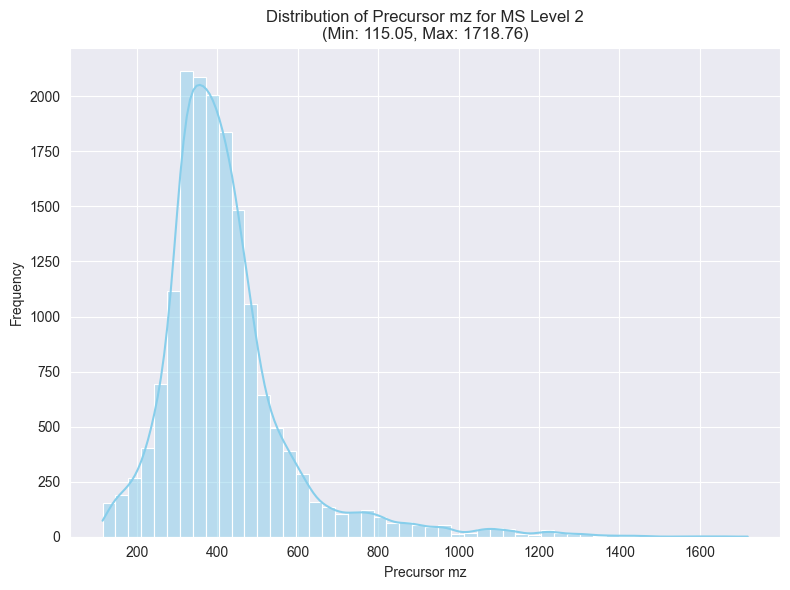

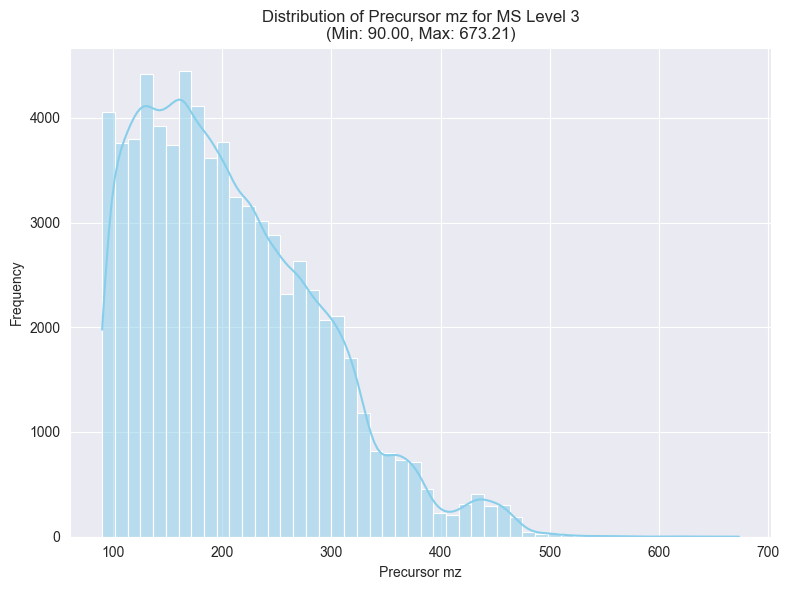

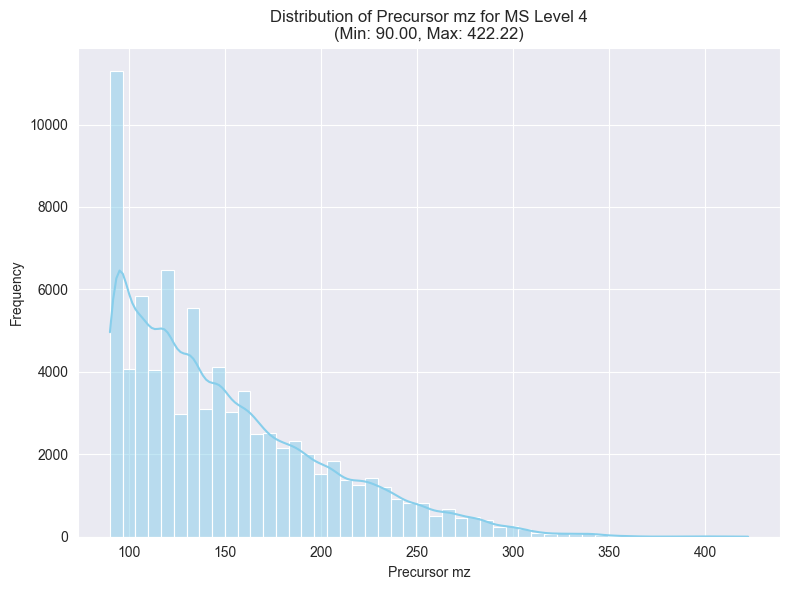

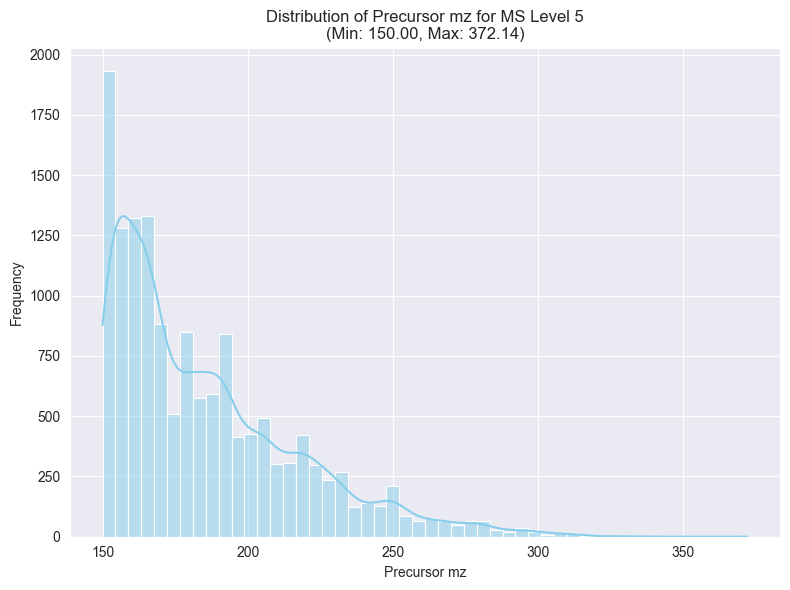

In [19]:
for level_i in data['ms_level'].unique():
    plot_attribute_distribution(data, ms_level=level_i, attribute='precursor_mz', output_svg=False)

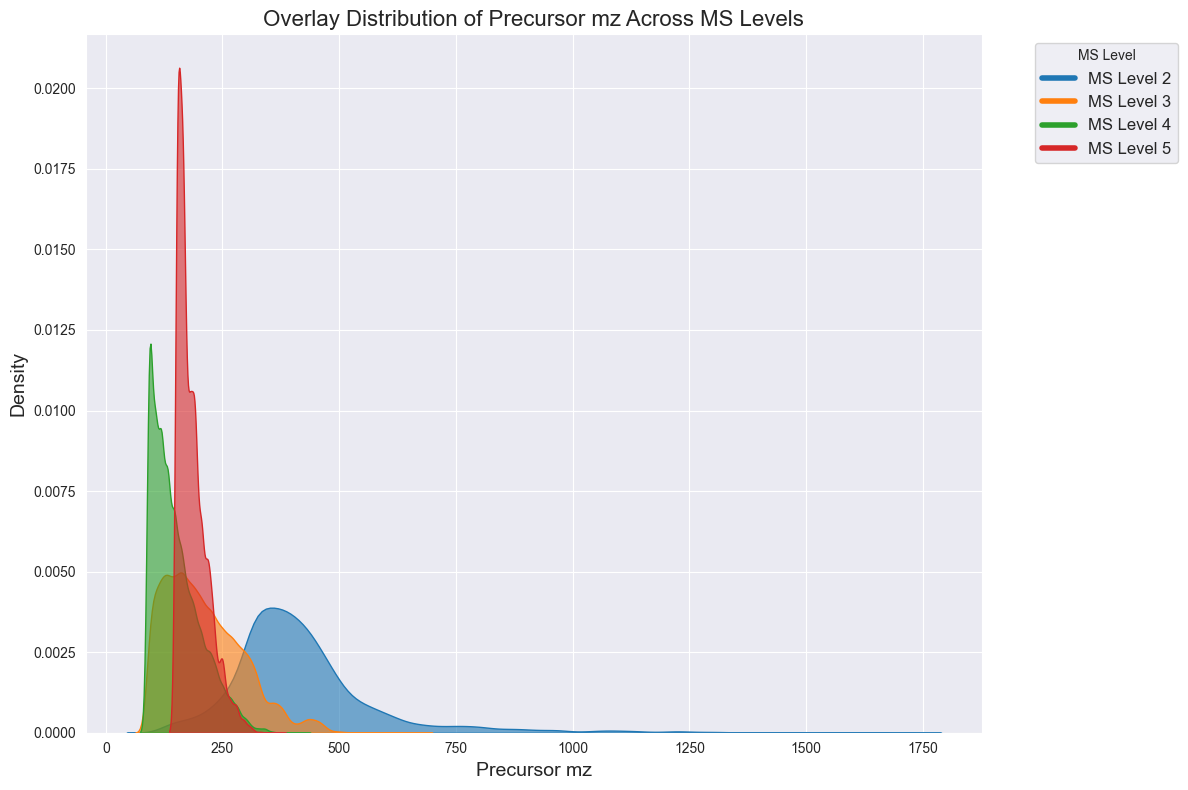

In [20]:
plot_attribute_overlay(data, attribute='precursor_mz', output_svg=False)

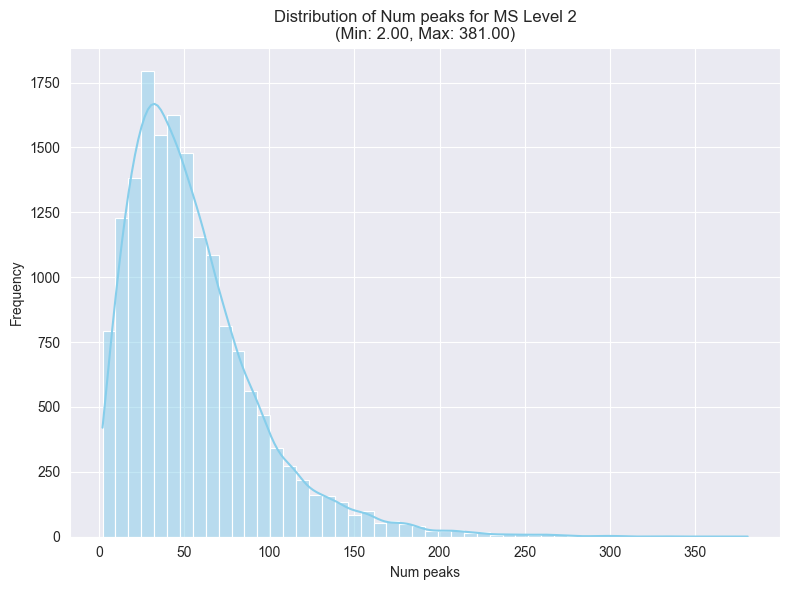

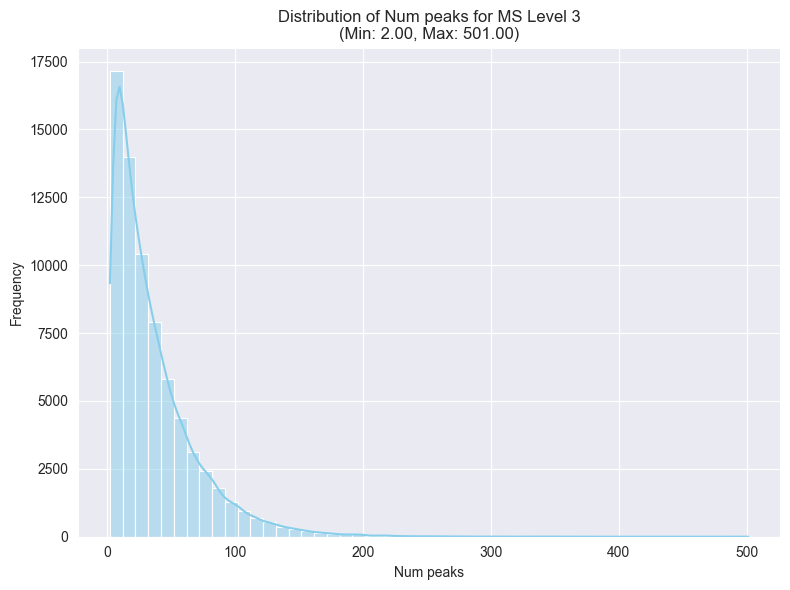

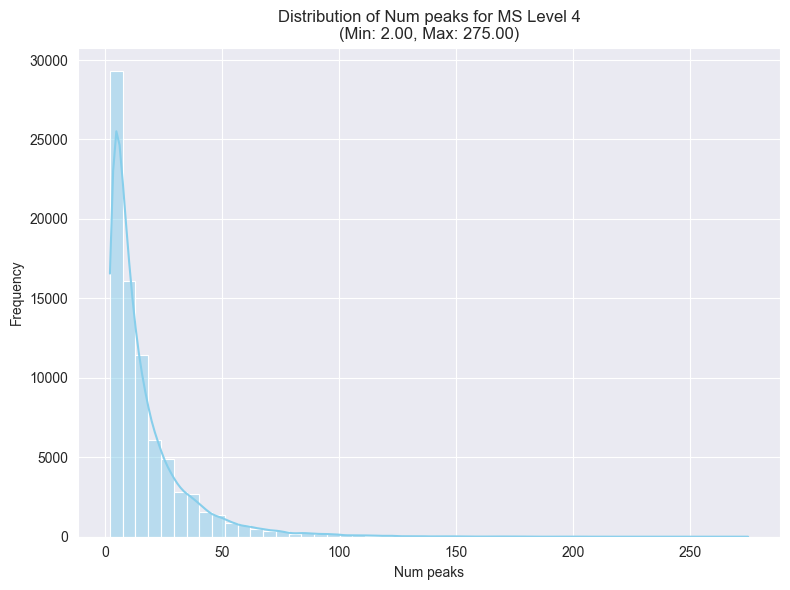

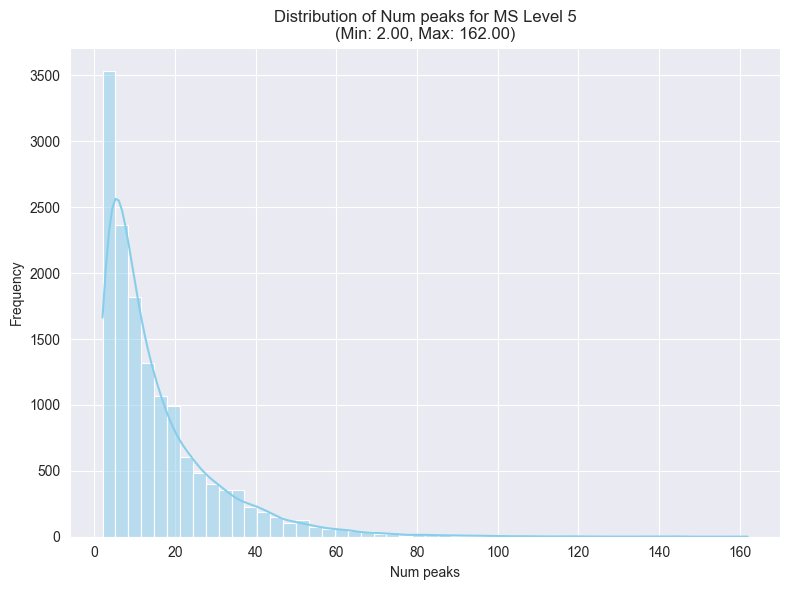

In [21]:
for level_i in data['ms_level'].unique():
    plot_attribute_distribution(data, ms_level=level_i, attribute='num_peaks', output_svg=False)

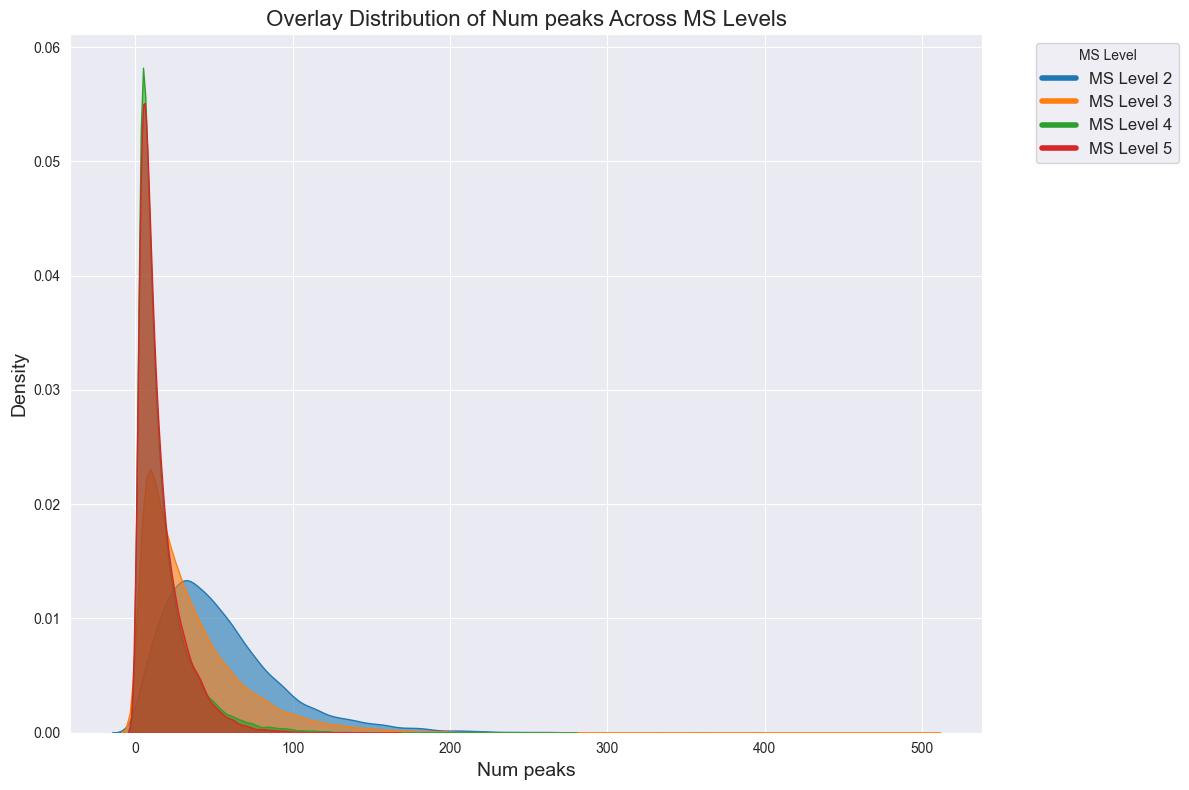

In [22]:
plot_attribute_overlay(data, attribute='num_peaks', output_svg=False)

## UMAP on DreaMS

In [23]:
# Extract embeddings as a 2D NumPy array
X = np.vstack(data['embedding'].values)

# Extract MS level labels
y = data['ms_level'].values

In [24]:
umap_reducer = umap.UMAP(n_neighbors=20, min_dist=0.2, metric='cosine', random_state=42)

# Fit and transform the data
X_umap = umap_reducer.fit_transform(X)

data['UMAP_1'] = X_umap[:, 0]
data['UMAP_2'] = X_umap[:, 1]

print("UMAP dimensionality reduction completed.")

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP dimensionality reduction completed.


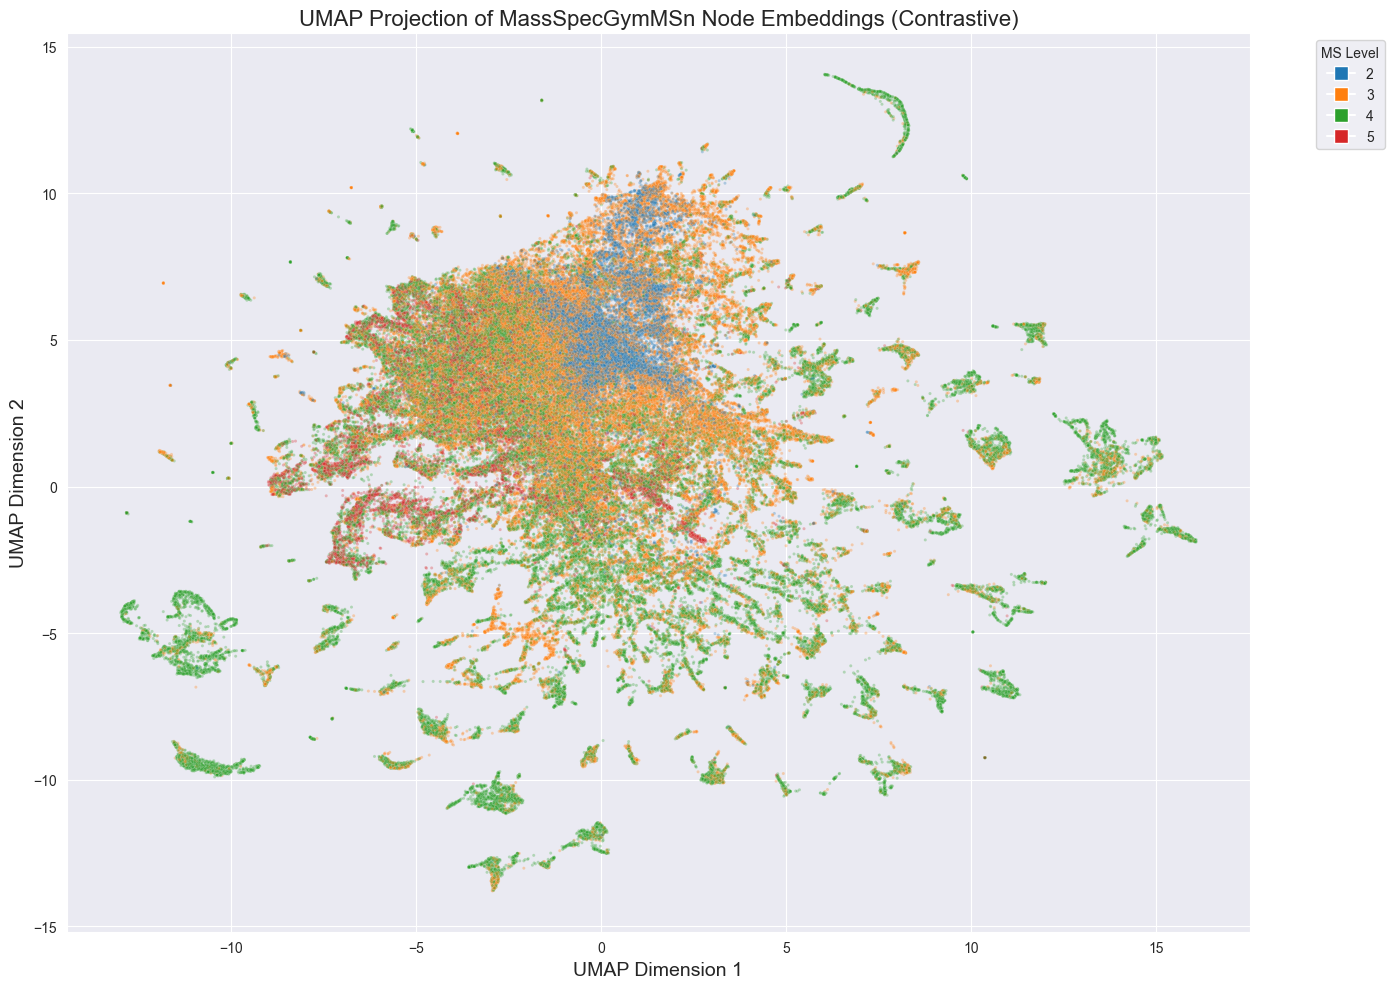

In [25]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))


scatter = sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='ms_level',
    palette='tab10',  
    data=data,
    legend='full',
    alpha=0.3, 
    s=5  
)


plt.title('UMAP Projection of MassSpecGymMSn Node Embeddings (Contrastive)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)


legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()


In [26]:
plot_umap_attribute(data, attribute='ms_level', is_continuous=False, alpha=0.3, s=5)


Sampling not applied: Using all data after filtering.


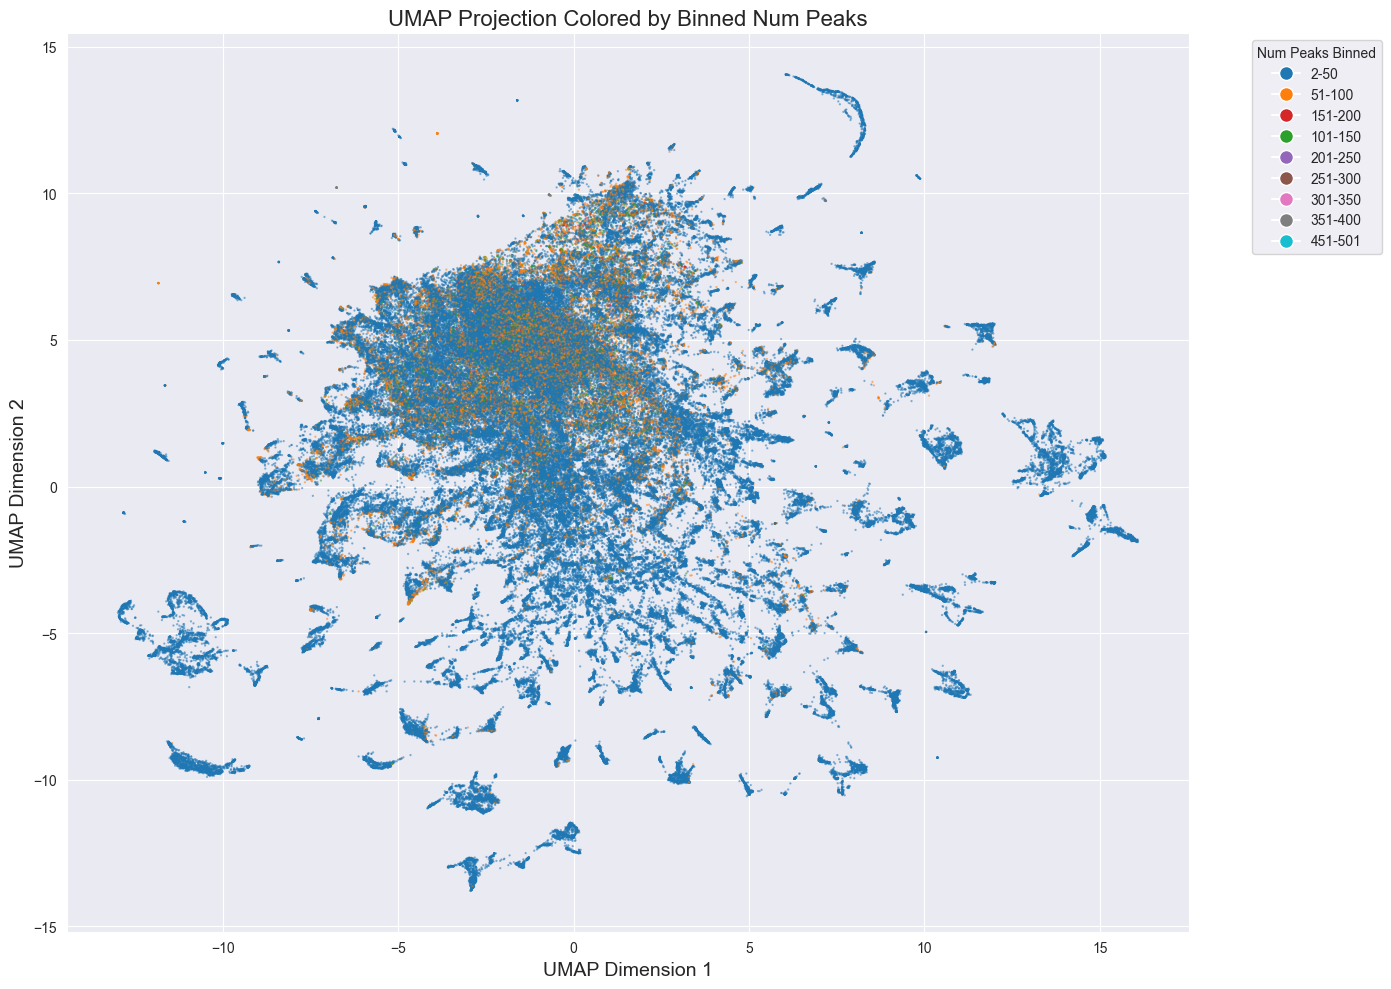

In [27]:
plot_umap_num_peaks(data, bins=10, output_svg=False)


Sampling not applied: Using all data after filtering.


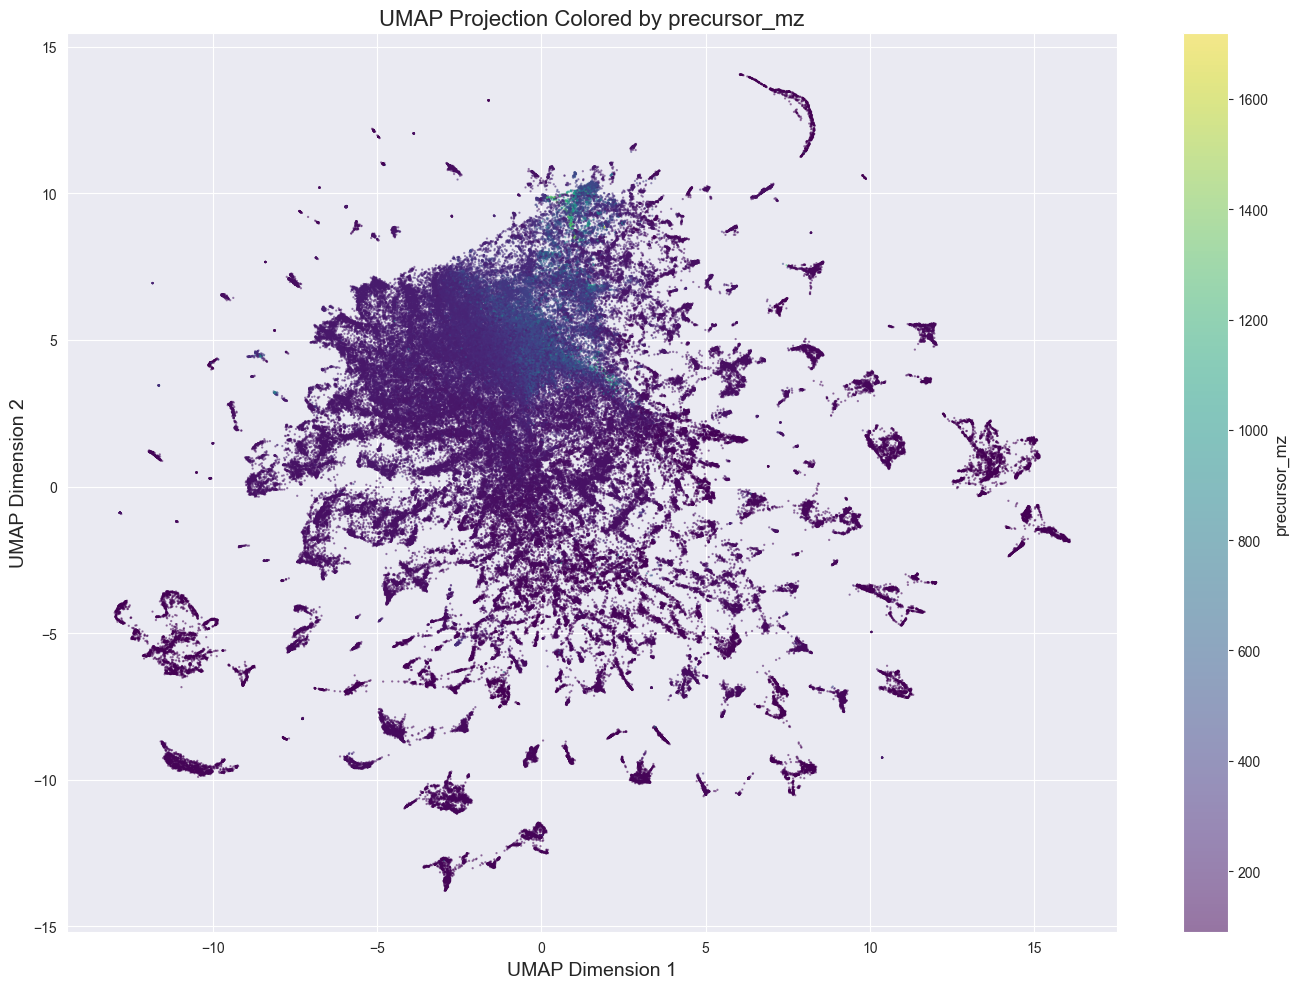

In [28]:
plot_umap_attribute(data, attribute='precursor_mz', alpha=0.5, s=0.4)

Applied max_num_peaks threshold: 30
Data points before thresholding: 183284
Data points after thresholding: 126375
No min_num_peaks threshold applied.
Bin '2-10': 63590 samples, sampled down to 5000.
Bin '11-19': 36440 samples, sampled down to 5000.
Bin '20-30': 26345 samples, sampled down to 5000.

Sampling applied: Each bin has at most max_per_bin samples.

Number of samples in each bin after sampling:
Bin Range  Sample Count
     2-10          5000
    11-19          5000
    20-30          5000


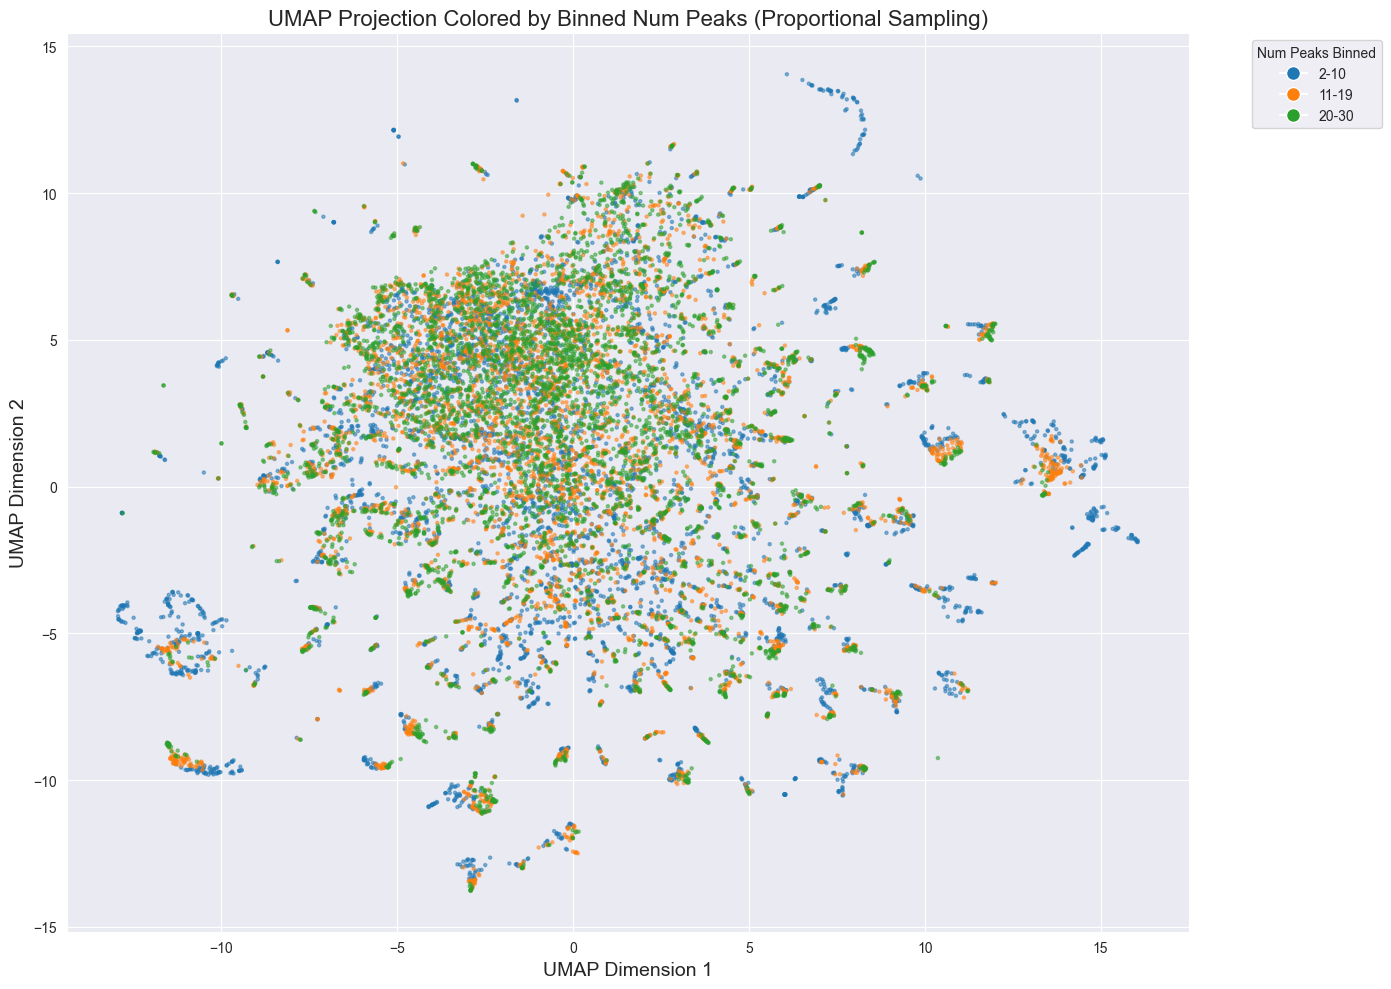

In [29]:
plot_umap_num_peaks_proportional(data, bins=3, sample_by_bins=True, max_per_bin=5000, max_num_peaks= 30, alpha=0.5, s=5, output_svg=False)


Applied max_num_peaks threshold: 5
Data points before thresholding: 183284
Data points after thresholding: 30970
Applied min_num_peaks threshold: 0
Data points before min thresholding: 30970
Data points after min thresholding: 30970
Bin '2-5': 30970 samples, sampled down to 10000.

Sampling applied: Each bin has at most max_per_bin samples.

Number of samples in each bin after sampling:
Bin Range  Sample Count
      2-5         10000


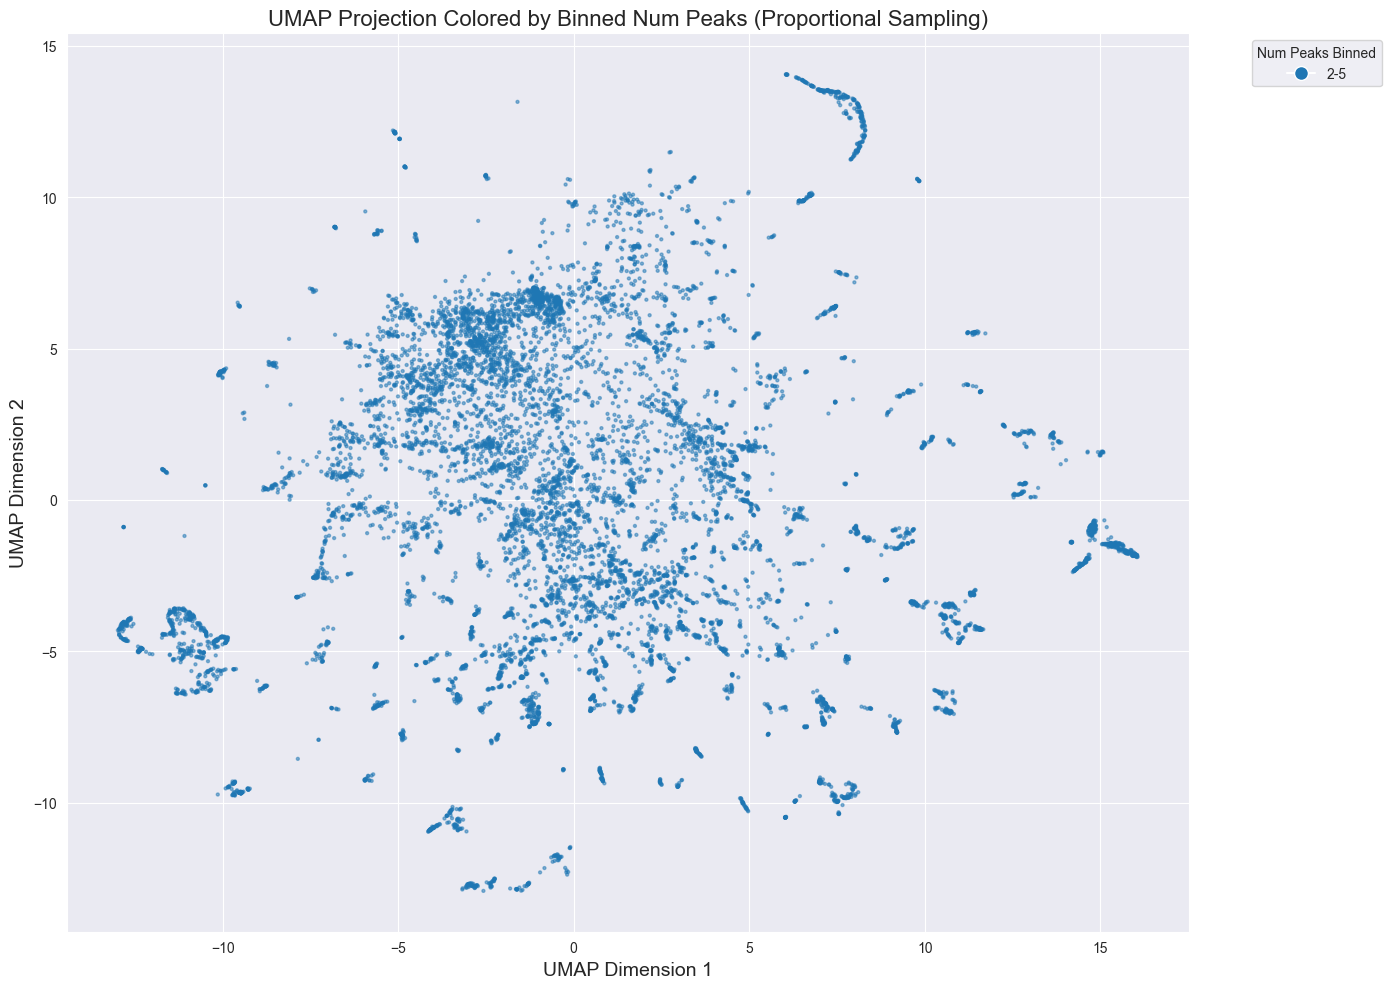

In [30]:
plot_umap_num_peaks_proportional(
    data,
    bins=1,
    sample_by_bins=True,
    max_per_bin=10000,
    max_num_peaks=5,
    min_num_peaks=0,
    alpha=0.5,
    s=4.5,
    output_svg=False
)

Applied max_num_peaks threshold: 5
Data points before thresholding: 183284
Data points after thresholding: 30970
Applied min_num_peaks threshold: 0
Data points before min thresholding: 30970
Data points after min thresholding: 30970

Sampling applied: Each ms_level has at most max_point samples.
ms_level '2': 358 samples, retained all.
ms_level '3': 6648 samples, sampled down to 1000.
ms_level '4': 20431 samples, sampled down to 1000.
ms_level '5': 3533 samples, sampled down to 1000.

Number of samples in each ms_level after sampling:
ms_level '2': 358 samples.
ms_level '3': 1000 samples.
ms_level '4': 1000 samples.
ms_level '5': 1000 samples.


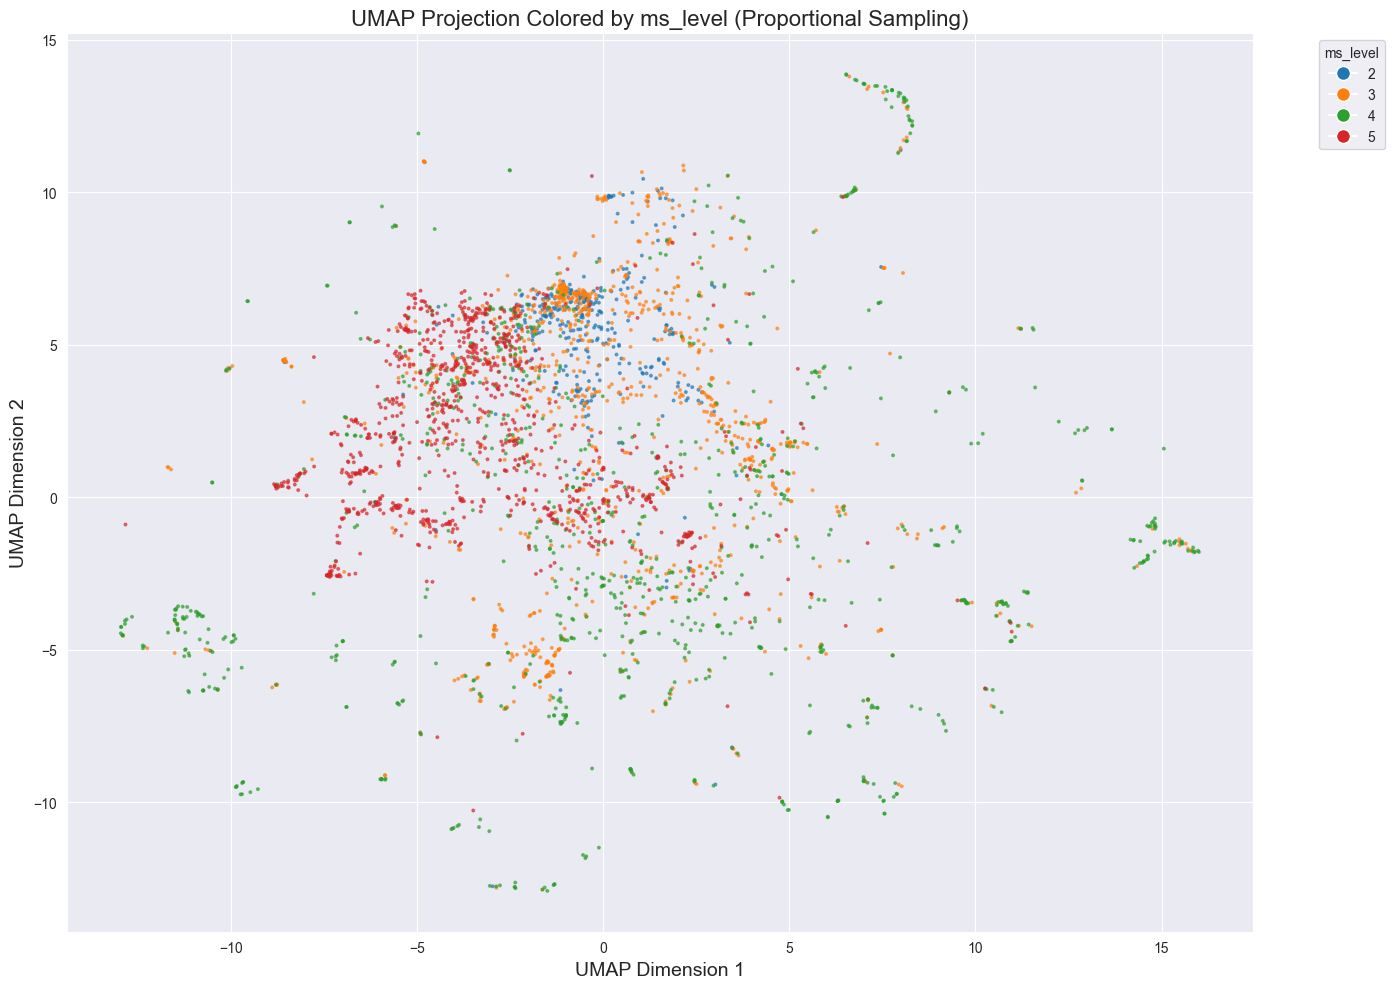

In [31]:
plot_umap_ms_level_proportional(
    data,
    max_point=1000,
    max_num_peaks=5,
    min_num_peaks=0,
    alpha=0.6,
    s=3.5,
    output_svg=False)

Applied min_num_peaks threshold: 0
Data points before min filtering: 183284
Data points after min filtering: 183284
Applied max_num_peaks threshold: 5
Data points before max filtering: 183284
Data points after max filtering: 30970

Sampling not applied: Using all data after filtering.


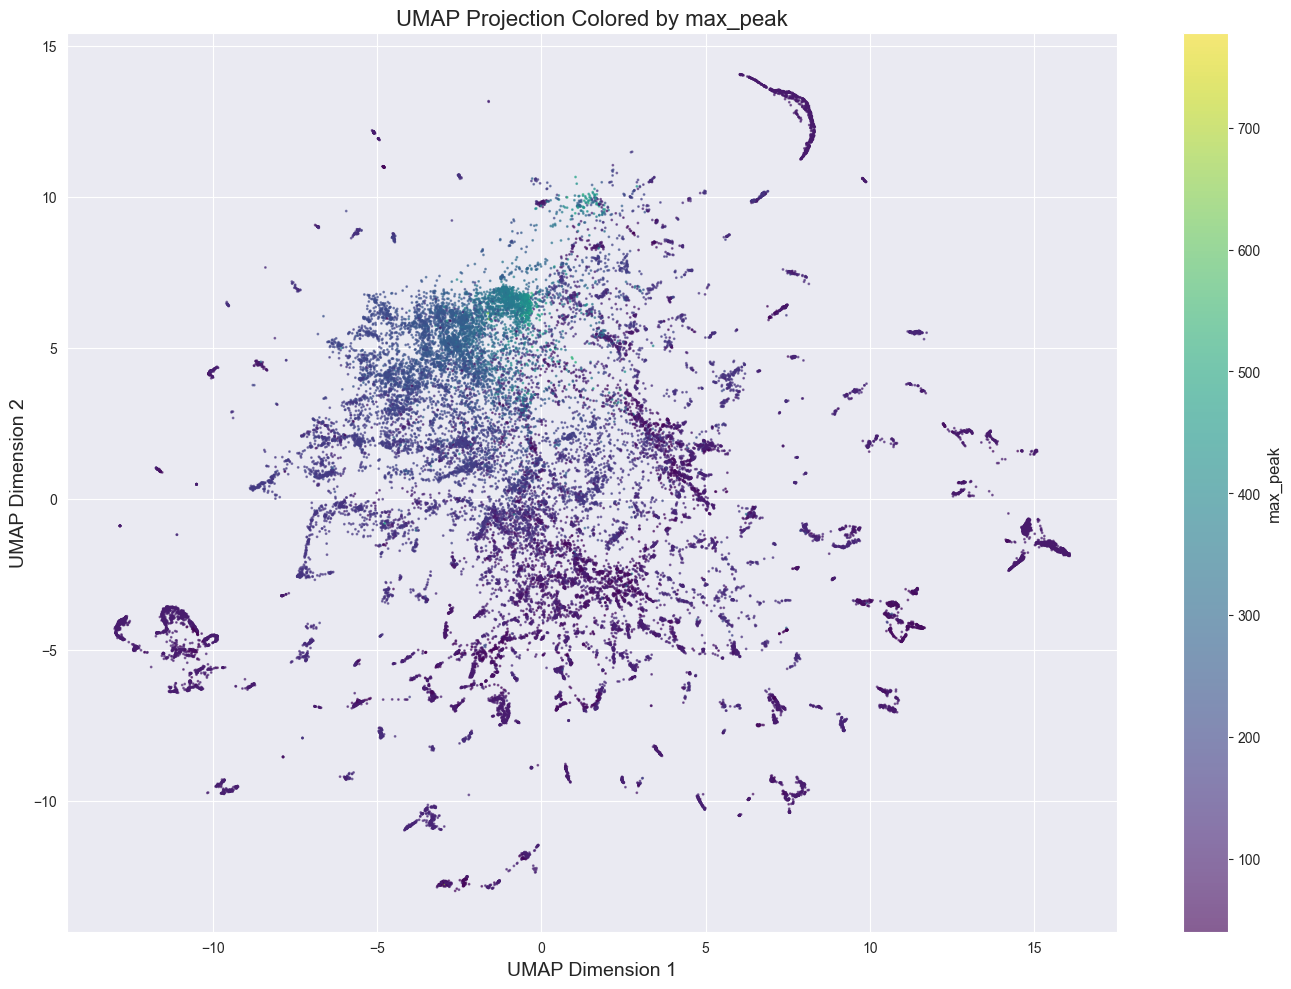

In [32]:
plot_umap_attribute(
    data=data,
    min_num_peaks=0,
    max_num_peaks=5,
    samples=None,
    attribute="max_peak",
    alpha=0.6,
    s=1.0,
    output_svg=False
)

Applied min_num_peaks threshold: 0
Data points before min filtering: 34437
Data points after min filtering: 34437
Applied max_num_peaks threshold: 30
Data points before max filtering: 34437
Data points after max filtering: 31222

Sampling not applied: Using all data after filtering.


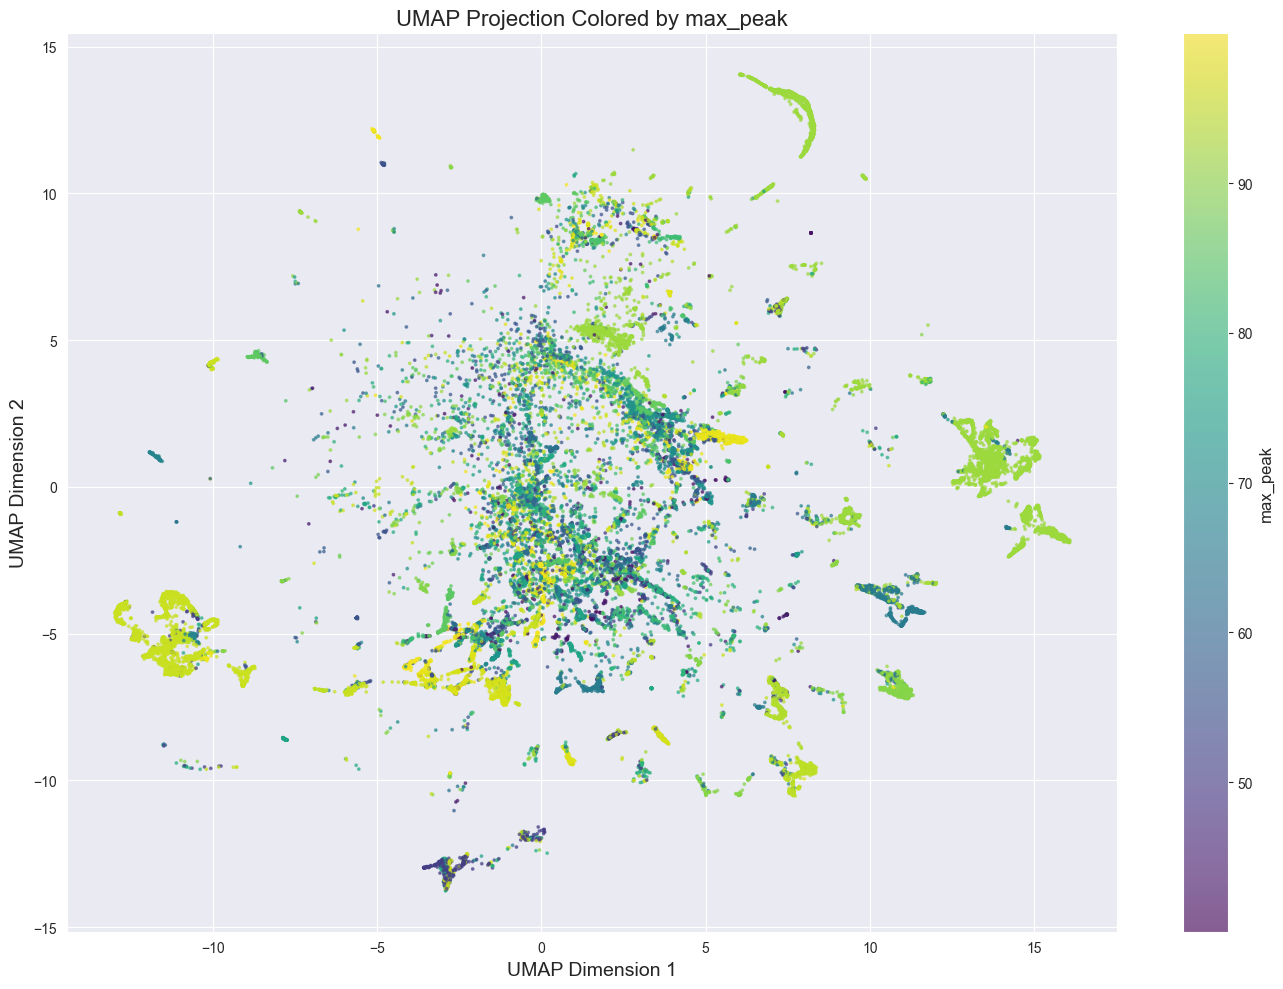

In [33]:
data_max_peak_reduced = data[data['max_peak'] < 100].copy()

plot_umap_attribute(
    data=data_max_peak_reduced,
    min_num_peaks=0,
    max_num_peaks=30,
    samples=None,
    attribute="max_peak",
    alpha=0.6,
    s=3.0,
    output_svg=False
)

Applied min_num_peaks threshold: 0
Data points before min filtering: 183284
Data points after min filtering: 183284
Applied max_num_peaks threshold: 5
Data points before max filtering: 183284
Data points after max filtering: 30970

Sampling not applied: Using all data after filtering.


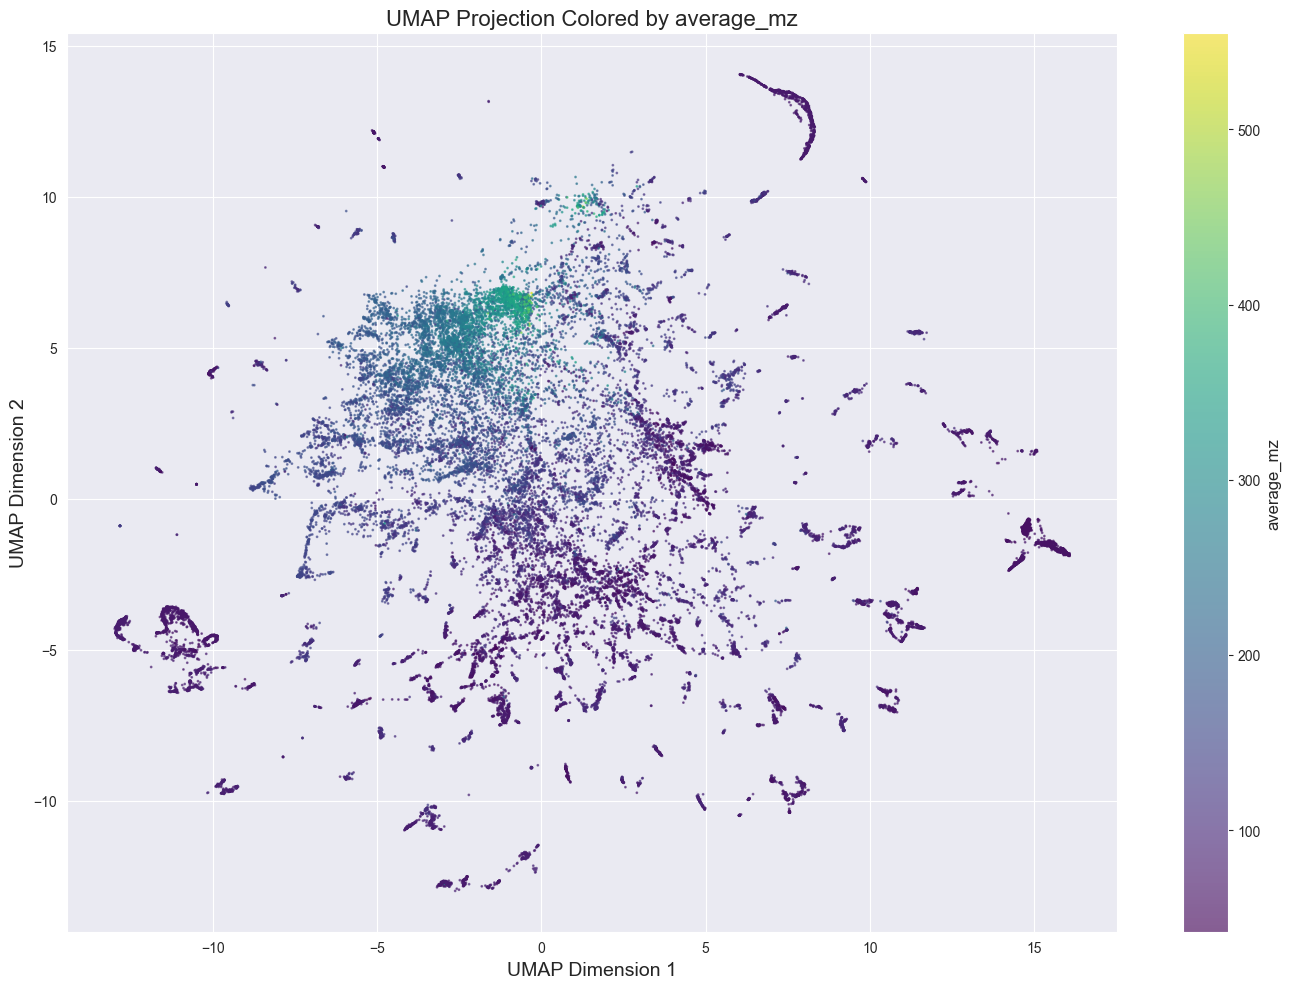

In [34]:
plot_umap_attribute(
    data=data,
    min_num_peaks=0,
    max_num_peaks=5,
    samples=None,
    attribute="average_mz",
    alpha=0.6,
    s=1.0,
    output_svg=False
)

Applied min_num_peaks threshold: 0
Data points before min filtering: 61768
Data points after min filtering: 61768
Applied max_num_peaks threshold: 5
Data points before max filtering: 61768
Data points after max filtering: 15133

Sampling not applied: Using all data after filtering.


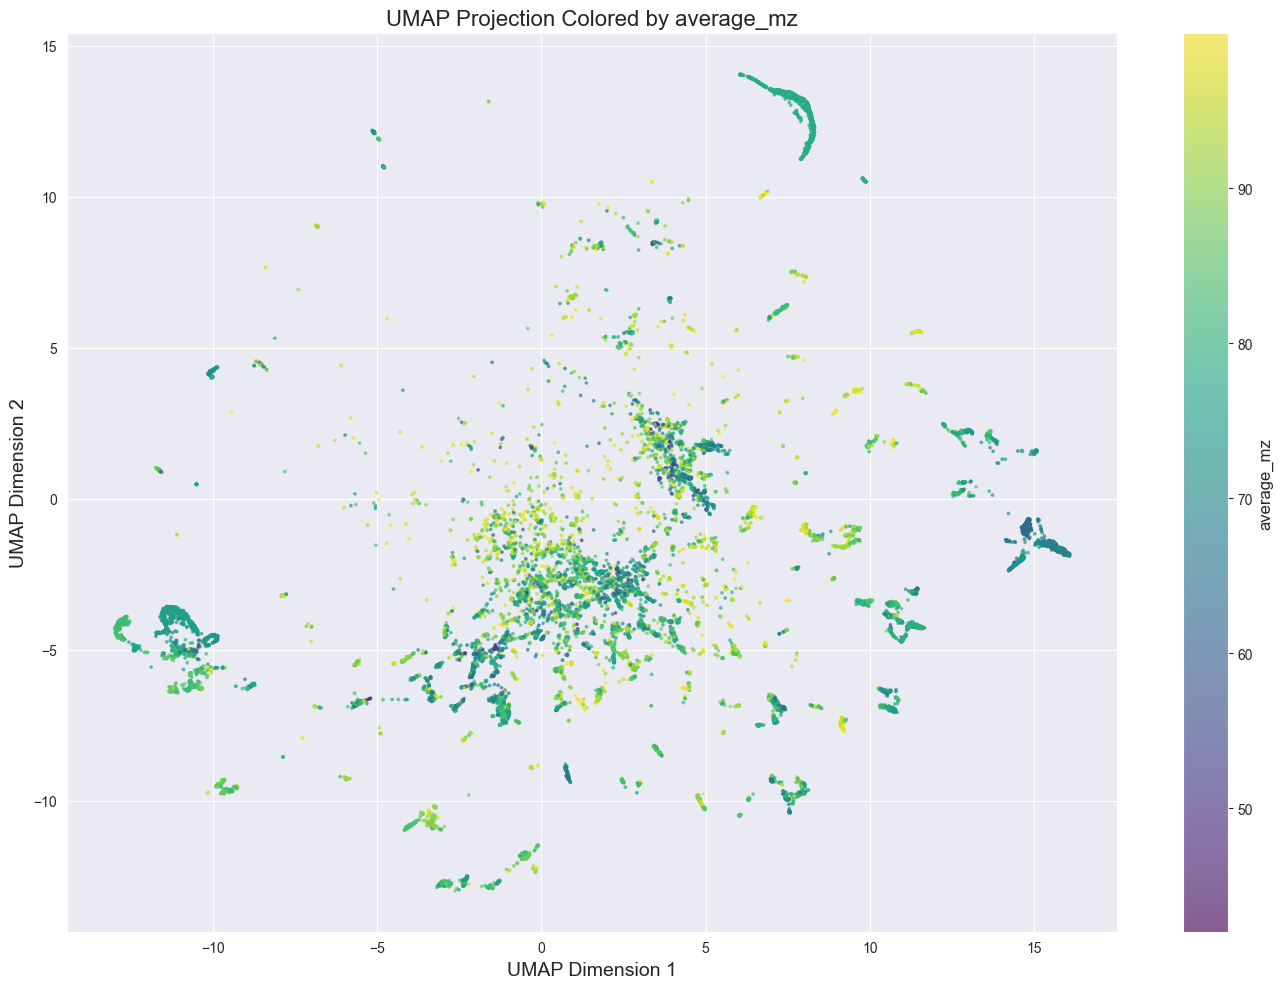

In [35]:
data_average_mz_reduced = data[data['average_mz'] < 100].copy()

plot_umap_attribute(
    data=data_average_mz_reduced,
    min_num_peaks=0,
    max_num_peaks=5,
    samples=None,
    attribute="average_mz",
    alpha=0.6,
    s=3.0,
    output_svg=False
)

Applied min_num_peaks threshold: 0
Data points before min filtering: 61768
Data points after min filtering: 61768
Applied max_num_peaks threshold: 30
Data points before max filtering: 61768
Data points after max filtering: 54566

Sampling not applied: Using all data after filtering.


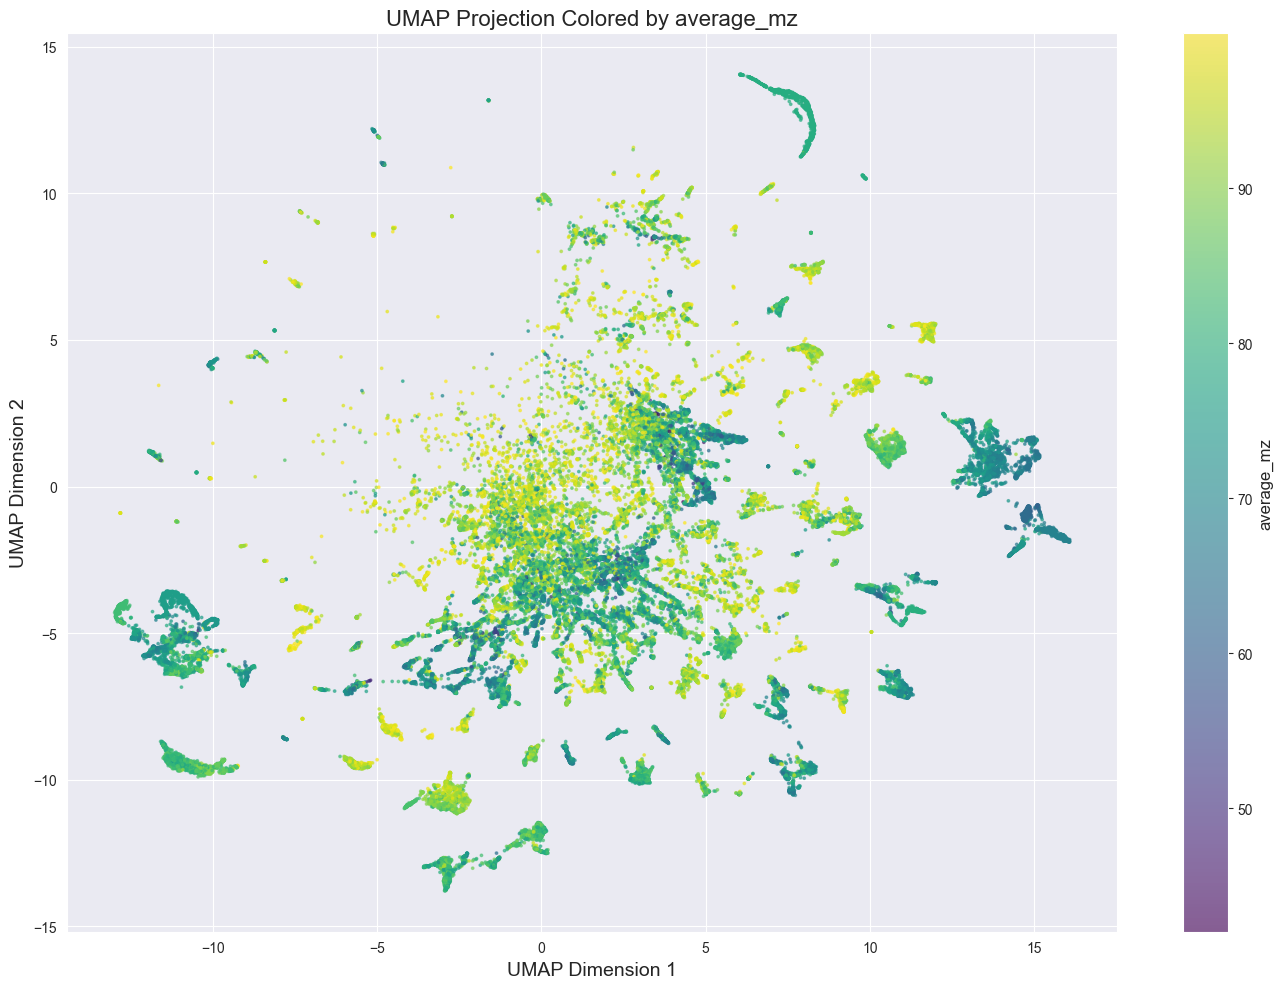

In [36]:
# show dominace of one significant peak
plot_umap_attribute(
    data=data_average_mz_reduced,
    min_num_peaks=0,
    max_num_peaks=30,
    samples=None,
    attribute="average_mz",
    alpha=0.6,
    s=3.0,
    output_svg=False
)

16609

Sampling not applied: Using all data after filtering.


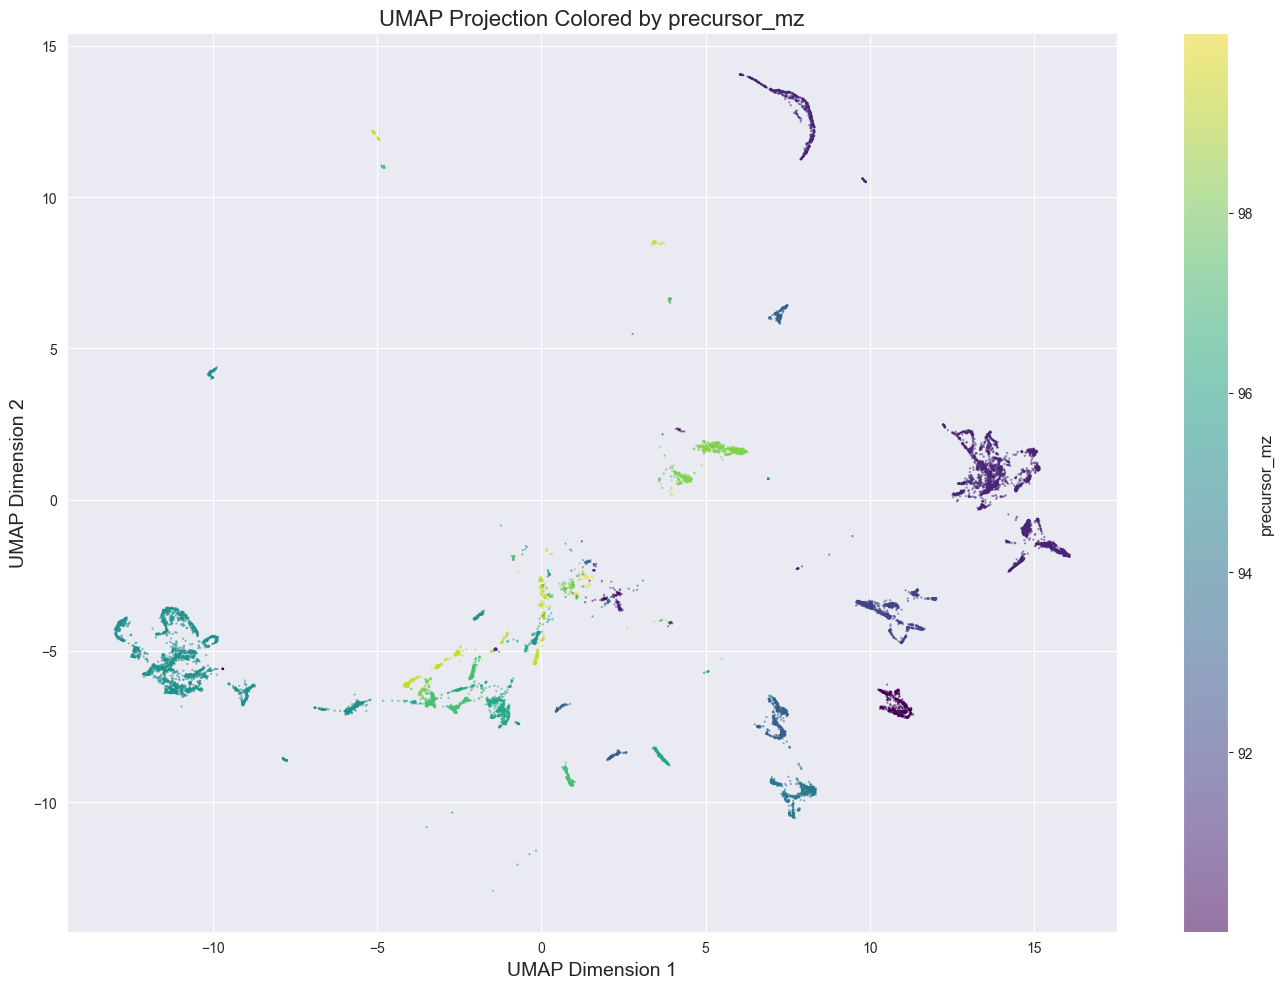

In [37]:
data_average_mz_and_precursor_mz_reduced = data_average_mz_reduced[data_average_mz_reduced['precursor_mz'] < 100].copy()
print(len(data_average_mz_and_precursor_mz_reduced))
plot_umap_attribute(data_average_mz_and_precursor_mz_reduced, attribute='precursor_mz', alpha=0.5, s=0.4)


Sampling not applied: Using all data after filtering.


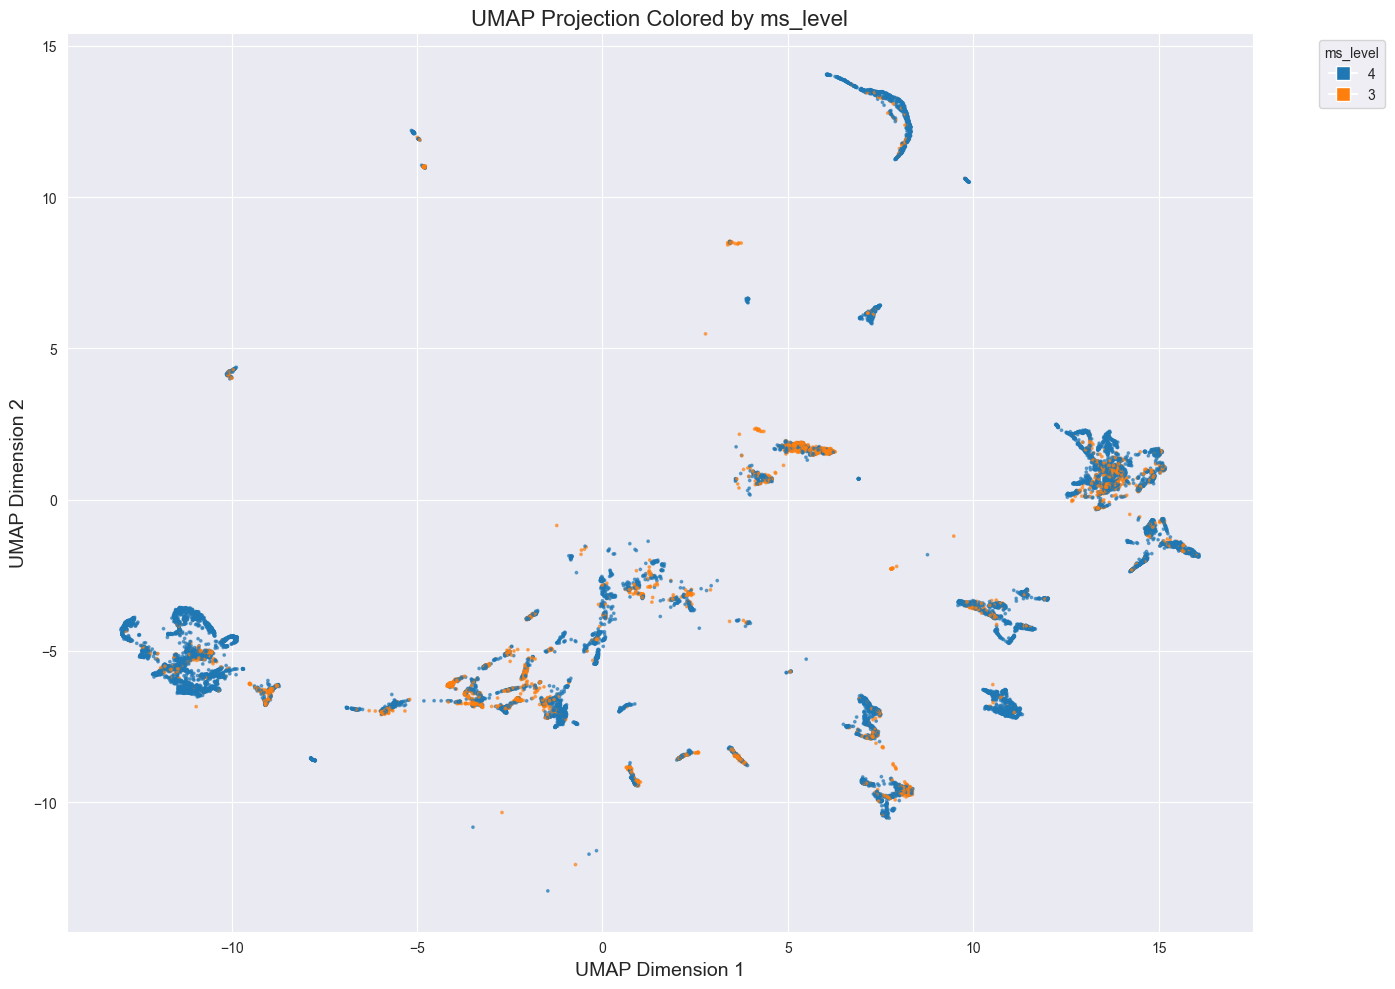

In [38]:
plot_umap_attribute(data_average_mz_and_precursor_mz_reduced, attribute='ms_level', is_continuous=False,output_svg=False)

## Investigation of one cluster

In [39]:
data_average_mz_and_precursor_mz_reduced.keys()

Index(['node_id', 'smiles', 'embedding', 'ms_level', 'tree_id', 'precursor_mz',
       'num_peaks', 'spectrum', 'max_peak', 'average_mz', 'average_intensity',
       'original_canonized_smiles', 'kingdom', 'superclass', 'class',
       'subclass', 'UMAP_1', 'UMAP_2'],
      dtype='object')

In [40]:
subset = data[
    (data['UMAP_1'] > 7.1) &
    (data['UMAP_2'] < 6.2) &
    (data['UMAP_2'] > 5.8) &
    (data['UMAP_1'] < 7.3)
]



Sampling not applied: Using all data after filtering.


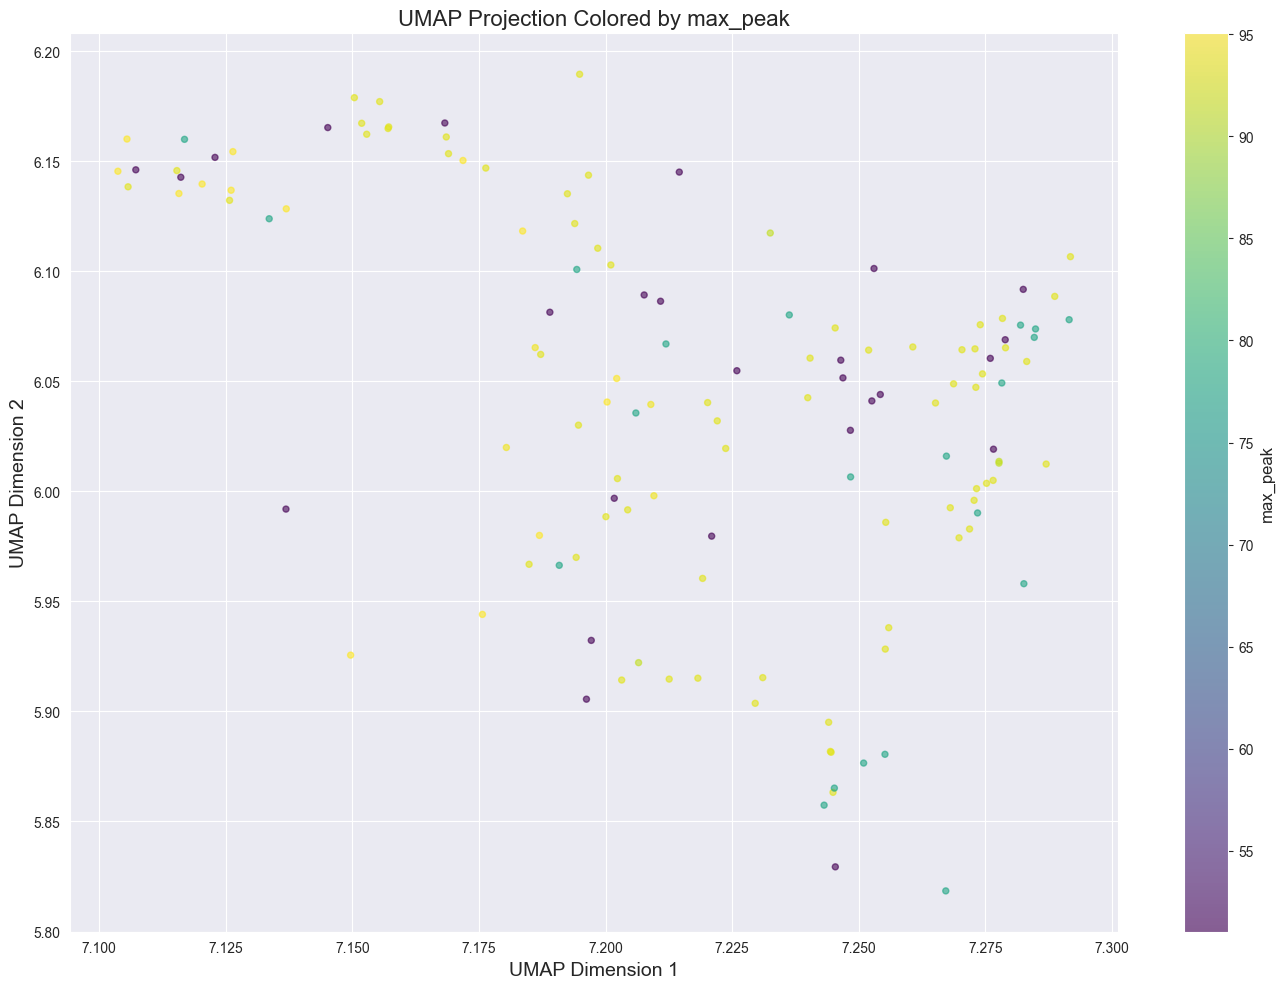

In [41]:
plot_umap_attribute(subset, attribute='max_peak', is_continuous=True, s=19, output_svg=False)


In [42]:
subset = subset[subset['max_peak'] > 87]

In [43]:
subset['class'].nunique()

27

In [44]:
subset['class'].unique()

array(['Fatty Acyls', 'Pyrans', 'Carboxylic acids and derivatives',
       'Saccharolipids', 'Prenol lipids', 'Tannins', 'Macrolactams',
       'Cinnamic acids and derivatives', 'Organonitrogen compounds',
       'Tropane alkaloids', 'Pyrrolidines',
       'Benzene and substituted derivatives',
       'Azaspirodecane derivatives', 'Thienopyrimidines',
       'Pyridines and derivatives', 'Piperidines', 'Triazines',
       'Indoles and derivatives', 'Phenols',
       'Steroids and steroid derivatives', 'Cytochalasans',
       'Macrolides and analogues', 'Diazinanes', 'Benzimidazoles',
       'Sphingolipids', 'Quinuclidines', 'Tetrahydroisoquinolines'],
      dtype=object)

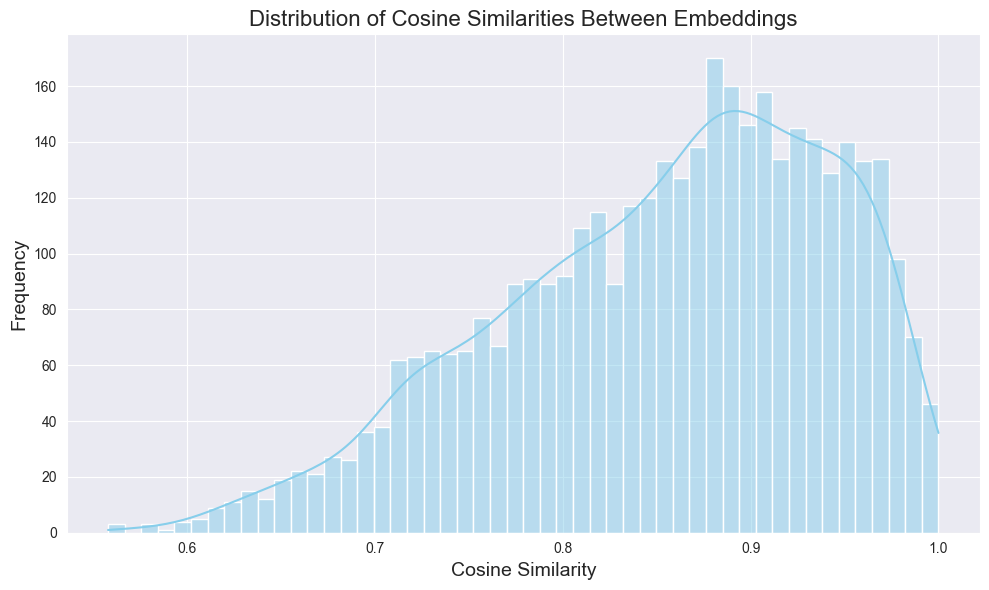

In [45]:
plot_cosine_similarity_distribution(subset)

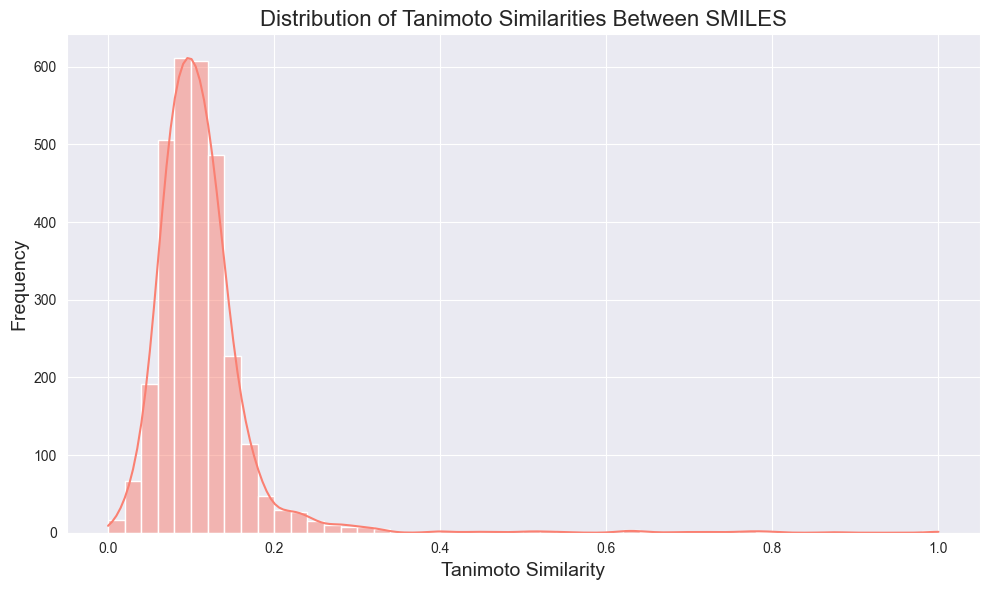

In [46]:
plot_tanimoto_similarity_distribution(subset)

Computing cosine similarities for 3828 pairs...


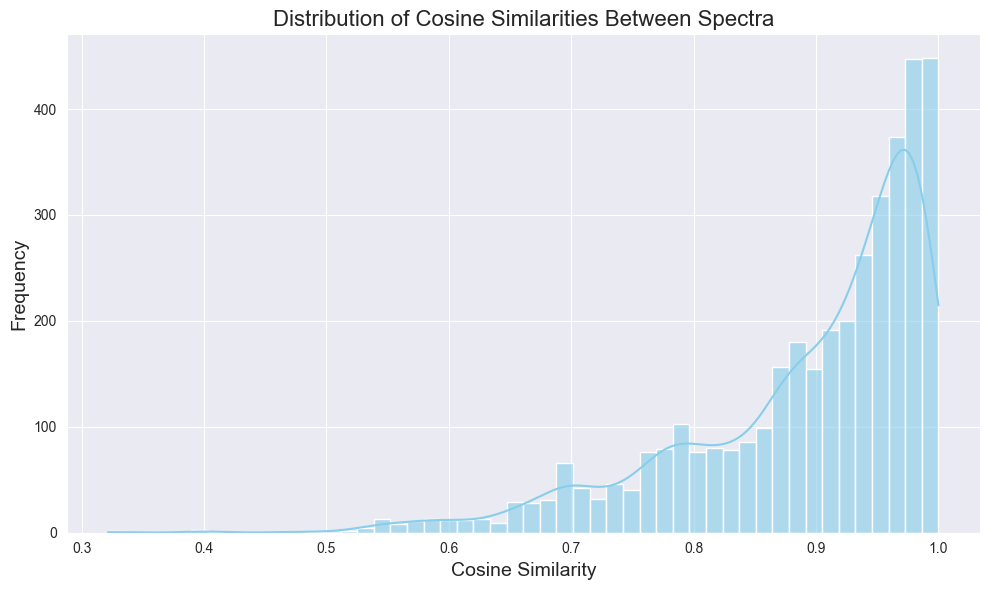

In [47]:
plot_cosine_similarity_distribution_on_spectra(subset)

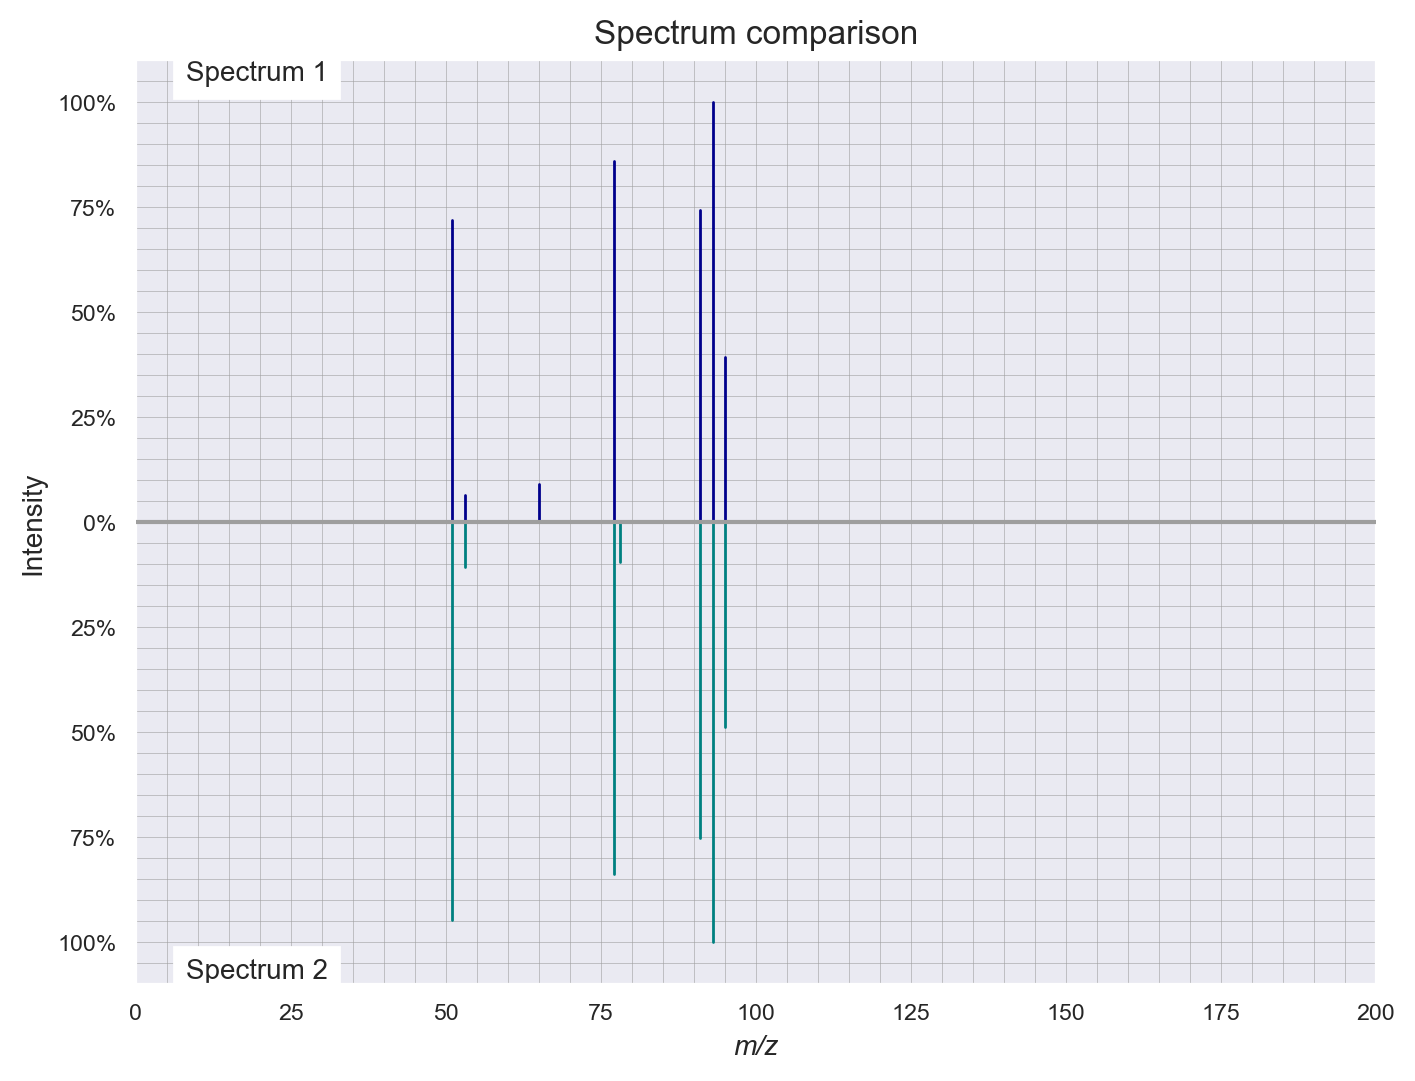

In [48]:
plot_random_spectra_comparison(subset)